# Setup and install relevant packages
This notebook assumes you are using Conda and have installed requirements from the associated `environment_reqs.yaml` file. To create a new Conda environment capable of running the code below, run:
```bash
conda env create -f environment_reqs.yaml
```
If you have already installed the environment and need to activate it, run:
```bash
conda activate research
conda list # confirm installed packages
```

In [252]:
!pip install ipykernel
!pip install plotly
!pip install --upgrade nbformat
!pip install igraph
!pip install scipy
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scikit-network
!pip install scikit-fuzzy
!pip install scikit-fuzzy
!pip install statsmodels
!pip install plotnine
!pip install binsreg
!pip install seaborn


In [177]:
import os
from io import StringIO
import copy

## TODO(Sort)
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import requests

import plotly.graph_objects as go
import statsmodels.formula.api as smf
from plotnine import *
from binsreg import *
import seaborn as sns

In [178]:
## TODO(helpers aren't used until below why here)
def inter(dfa, dfb):
    return list(set(dfa.columns) & set(dfb.columns))


def merge_df(dfa, dfb, how="outer"):
    return dfa.merge(dfb, on=inter(dfa, dfb), how=how)

# Preprocessing data / merging

## Load datasets
The top-level analysis pulls data from three sources:
1. [BLS Employment data](https://www.bls.gov/oes/2021/may/oes_nat.htm#00-0000): Number of employees by occupation type, pulled August 9, 2023
2. [Labeled task data](data/full_labelset.tsv): mapping of occupation type against model exposure
3. [O*NET Database](https://www.onetcenter.org/database.html): Work, worker characteristics and skill requirements across occupations, the dataframe here is compiled by merging those below and dropping tasks with no associated occupations and vice versa
    * [Occupation Data](https://www.onetcenter.org/dl_files/database/db_27_1_text/Occupation%20Data.txt)
    * [Task Statements](https://www.onetcenter.org/dl_files/database/db_27_1_text/Task%20Statements.txt)
    * [Detailed Work Activities](https://www.onetcenter.org/dl_files/database/db_27_1_text/DWA%20Reference.txt)
    * [Task Ratings](https://www.onetcenter.org/dl_files/database/db_27_2_text/Task%20Ratings.txt)

In [179]:
def read_tsv(path):
    """
    Load TSV using pandas
    """
    return pd.read_csv(path, delimiter="\t")


bls_oews = pd.read_csv("../data/national_May2021_dl.csv")
full_labels = read_tsv("../data/full_labelset.tsv")
full_labels.rename(
    columns={
        "gpt4_exposure_alt_rubric": "gpt4_alt_exposure",
        "human_exposure_agg": "human_exposure",
    },
    inplace=True,
)
df_tasks = read_tsv("../data/full_onet_data.tsv")

## Translate categorical data

In [180]:
alpha_score_map = {"E0": 0.0, "E1": 1.0, "E2": 0.0, "E3": 0.0}
beta_score_map = {"E0": 0.0, "E1": 1.0, "E2": 0.5, "E3": 0.5}
gamma_score_map = {"E0": 0.0, "E1": 1.0, "E2": 1.0, "E3": 1.0}
t_score_map = {"T0": 0.0, "T1": 0.25, "T2": 0.5, "T3": 0.75, "T4": 1.0}

for prefix in ["gpt4", "human"]:
    full_labels[f"{prefix}_alpha"] = full_labels[f"{prefix}_exposure"].apply(
        lambda x: alpha_score_map[x]
    )
    full_labels[f"{prefix}_beta"] = full_labels[f"{prefix}_exposure"].apply(
        lambda x: beta_score_map[x]
    )
    full_labels[f"{prefix}_gamma"] = full_labels[f"{prefix}_exposure"].apply(
        lambda x: gamma_score_map[x]
    )

full_labels["gpt4_alt_beta"] = full_labels["gpt4_alt_exposure"].apply(
    lambda x: beta_score_map[x]
)

full_labels["automation"] = full_labels["gpt4_automation"].apply(
    lambda x: t_score_map[x]
)

## Add in weights

We consider four different weightings for tasks within an occupation:
* Importance: IM weights from O*NET
* Relevance: RT weights from O*NET
* Core: Core vs. supplemental labels from O*NET. Core gets twice the weight of Supplemental. Missing values default to supplemental.
* Equal: Equal weight over all tasks in an occupation.

In [181]:
df_taskratings = read_tsv(
    "https://www.onetcenter.org/dl_files/database/db_27_2_text/Task%20Ratings.txt"
)

df_taskratings_relevant = df_taskratings[df_taskratings["Scale ID"].isin(["RT", "IM"])][
    ["O*NET-SOC Code", "Task ID", "Scale ID", "Data Value"]
]
dfr_taskratings = pd.pivot(
    df_taskratings_relevant, index=["O*NET-SOC Code", "Task ID"], columns=["Scale ID"]
).reset_index()
dfr_taskratings.columns = ["O*NET-SOC Code", "Task ID", "importance", "relevance"]

# converting the core / supplemental rating to a numerical weight where core is worth 2x the taskweight of a supplemental task.
df_tasks["coreweight"] = df_tasks["Task Type"].map(
    {"Core": 2, "Supplemental": 1, np.nan: 1}
)
df_tasks["equalweight"] = df_tasks["Task Type"].map(
    {"Core": 1, "Supplemental": 1, np.nan: 1}
)
task_tmp = pd.merge(df_tasks, dfr_taskratings, how="left")

In [182]:
impWeightOcc = (
    task_tmp[["O*NET-SOC Code", "importance", "relevance", "coreweight", "equalweight"]]
    .groupby("O*NET-SOC Code")
    .sum()
    .reset_index()
)
impWeightOcc.rename(
    columns={
        "importance": "impTotal",
        "relevance": "relTotal",
        "coreweight": "coreweightTotal",
        "equalweight": "equalweightTotal",
    },
    inplace=True,
)
task_tmp_weighted = pd.merge(task_tmp, impWeightOcc, how="left", on="O*NET-SOC Code")
task_tmp_weighted["importance_weight"] = (
    task_tmp_weighted["importance"] / task_tmp_weighted["impTotal"]
)
task_tmp_weighted["relevance_weight"] = (
    task_tmp_weighted["relevance"] / task_tmp_weighted["relTotal"]
)
task_tmp_weighted["core_weight"] = (
    task_tmp_weighted["coreweight"] / task_tmp_weighted["coreweightTotal"]
)
task_tmp_weighted["equal_weight"] = (
    task_tmp_weighted["equalweight"] / task_tmp_weighted["equalweightTotal"]
)

In [183]:
## merge weights to the label frame
full_labels_weight = pd.merge(
    full_labels,
    task_tmp_weighted[
        [
            "O*NET-SOC Code",
            "Task ID",
            "importance_weight",
            "relevance_weight",
            "core_weight",
            "equal_weight",
        ]
    ],
    how="left",
)

## scoring and labeling
full_labels_weight["gpt_relevant"] = full_labels_weight["gpt_3_relevant"].astype(float)

# Inspect data and agreement rates

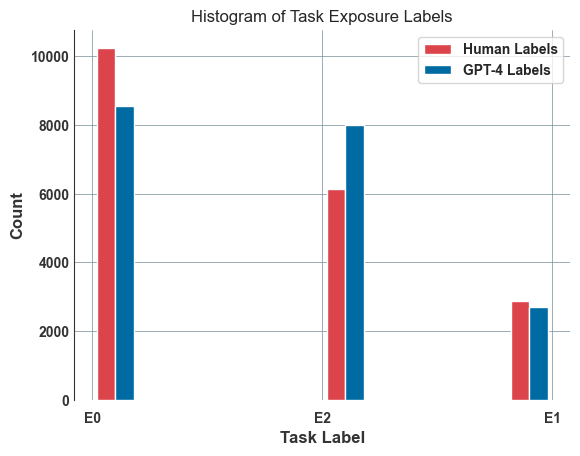

In [184]:
counts, bins, bars = plt.hist(full_labels[["human_exposure", "gpt4_exposure"]])
plt.legend(["Human Labels", "GPT-4 Labels"])
plt.title("Histogram of Task Exposure Labels")
plt.xlabel("Task Label")
plt.ylabel("Count")
plt.grid(visible=True, axis="x")

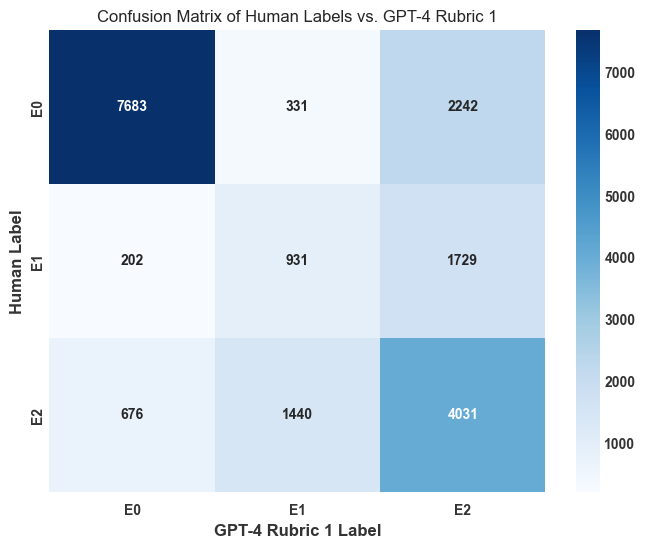

In [185]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Generate confusion matrix
cm = confusion_matrix(full_labels["human_exposure"], full_labels["gpt4_exposure"])

# OPTIONAL NORMALIZE
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# cm = cm.astype('float') / len(list(full_labels_weight['gpt4_exposure']))
cm = cm

# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    cmap="Blues",
    fmt=".0f",
    xticklabels=["E0", "E1", "E2"],
    yticklabels=["E0", "E1", "E2"],
)
plt.xlabel("GPT-4 Rubric 1 Label")
plt.ylabel("Human Label")
plt.title("Confusion Matrix of Human Labels vs. GPT-4 Rubric 1")
plt.show()

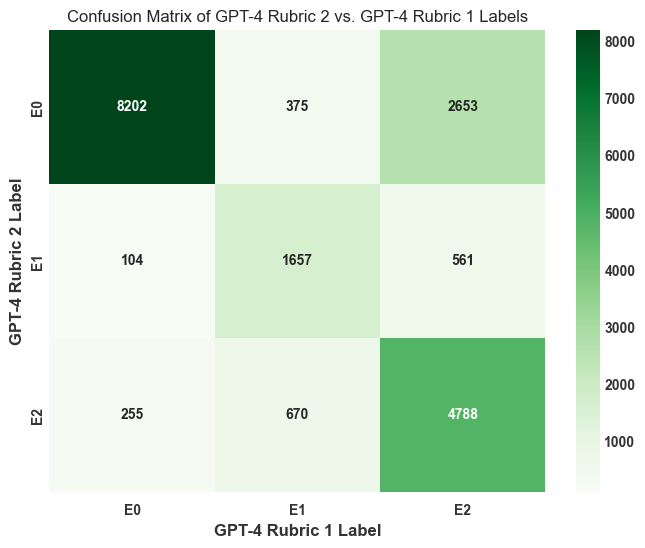

In [186]:
# Generate confusion matrix for GPT-4 Alternate Exposure Rubric vs. GPT-4 Main Exposure Rubric
cm_gpt = confusion_matrix(
    full_labels_weight["gpt4_alt_exposure"], full_labels_weight["gpt4_exposure"]
)

# OPTIONAL NORMALIZE
# cm_gpt = cm_gpt.astype('float') / cm_gpt.sum(axis=1)[:, np.newaxis]
# cm_gpt = cm_gpt.astype('float') / len(list(full_labels_weight['gpt4_exposure']))
cm_gpt = cm_gpt

# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_gpt,
    annot=True,
    cmap="Greens",
    fmt=".0f",
    xticklabels=["E0", "E1", "E2"],
    yticklabels=["E0", "E1", "E2"],
)
plt.ylabel("GPT-4 Rubric 2 Label")
plt.xlabel("GPT-4 Rubric 1 Label")
plt.title("Confusion Matrix of GPT-4 Rubric 2 vs. GPT-4 Rubric 1 Labels")
plt.show()

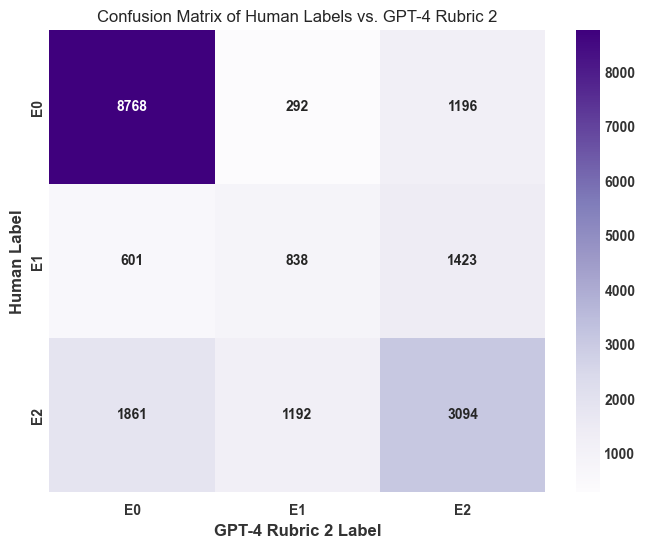

In [187]:
# Generate confusion matrix for human labels vs. GPT-4 Secondary Exposure (EE) rubric.
cm_gpt_alt = confusion_matrix(
    full_labels_weight["human_labels"], full_labels_weight["gpt4_alt_exposure"]
)

# Optional: normalize the confusion matrix
# cm_gpt_alt = cm_gpt_alt.astype("float") / cm_gpt_alt.sum(axis=1)[:, np.newaxis]
# cm_gpt_alt = cm_gpt_alt.astype("float") / len(
#     list(full_labels_weight["gpt4_alt_exposure"])
# )
cm_gpt_alt = cm_gpt_alt

# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_gpt_alt,
    annot=True,
    cmap="Purples",
    fmt=".0f",
    xticklabels=["E0", "E1", "E2"],
    yticklabels=["E0", "E1", "E2"],
)
plt.ylabel("Human Label")
plt.xlabel("GPT-4 Rubric 2 Label")
plt.title("Confusion Matrix of Human Labels vs. GPT-4 Rubric 2")
plt.show()

Now create occupation-level scores. Note the weighting scheme can be changed and alters scores.

In [188]:
def weighted_mean(df, groupfields, aggfields, weightfield):
    df2 = df[aggfields].multiply(df[weightfield], axis="index")
    aa = df[[weightfield] + groupfields]
    df3 = df2.join(aa)
    dfg = df3[groupfields + aggfields].groupby(groupfields).sum().reset_index()
    return dfg

In [189]:
## Must be one of {'equal_weight','core_weight','relevance_weight','importance_weight'}
weight_field = "equal_weight"

## How we are grouping tasks (by occupation)
group_fields = ["O*NET-SOC Code", "Title"]

## These are the fields that will be aggregated to the occupation-level
rating_fields = [
    "gpt4_alpha",
    "gpt4_beta",
    "gpt4_gamma",
    "human_alpha",
    "human_beta",
    "human_gamma",
    "automation",
    "gpt4_alt_beta",
]

## Run the weighting
occ_level = weighted_mean(full_labels_weight, group_fields, rating_fields, weight_field)

##### Agreement when aggregating to occupation level

Text(0.5, 1.0, 'Similarity of Human and GPT-4 Ratings by Occupation')

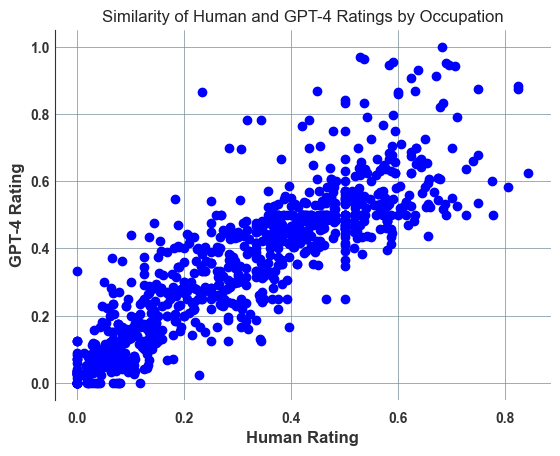

In [190]:
plt.scatter(occ_level["human_beta"], occ_level["gpt4_beta"], c="b")
plt.xlabel("Human Rating")
plt.ylabel("GPT-4 Rating")
plt.title("Similarity of Human and GPT-4 Ratings by Occupation")

Text(0.5, 1.0, 'Occupation-level GPT-4 Exposure Ratings vs. Human Exposure Ratings')

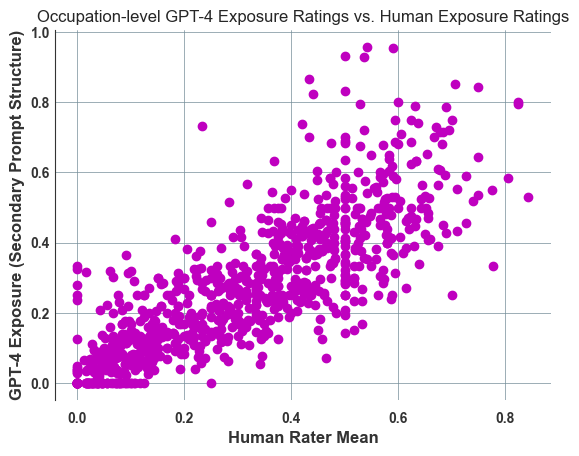

In [191]:
plt.scatter(occ_level["human_beta"], occ_level["gpt4_alt_beta"], c="m")
plt.xlabel("Human Rater Mean")
plt.ylabel("GPT-4 Exposure (Secondary Prompt Structure)")
plt.title("Occupation-level GPT-4 Exposure Ratings vs. Human Exposure Ratings")

In [192]:
def generate_binscatter(col1, col2, data, x_lab, y_lab, scale_x, scale_y, title):
    est = binsreg(
        col1,
        col2,
        data=data,
        line=(3, 3),
        ci=(3, 3),
        cb=(3, 3),
        polyreg=3,
        nbins=10,
        vce="HC3",
    )
    result = est.data_plot[0]

    # Create the figure to plot
    fig = ggplot() + labs(x=x_lab, y=y_lab)

    # Add the dots
    fig += geom_point(
        data=result.dots, mapping=aes(x="x", y="fit"), color="blue", size=2, shape="o"
    )

    # Add the line
    fig += geom_line(
        data=result.line, mapping=aes(x="x", y="fit"), color="blue", size=0.5
    )

    # Add the CI
    fig += geom_errorbar(
        data=result.ci,
        mapping=aes(x="x", ymin="ci_l", ymax="ci_r"),
        color="blue",
        size=0.5,
        width=0.02,
        linetype="solid",
    )

    # Add the CB
    fig += geom_ribbon(
        data=result.cb,
        mapping=aes(x="x", ymin="cb_l", ymax="cb_r"),
        fill="blue",
        alpha=0.2,
    )

    # Add the polyreg
    # fig += geom_line(data=result.poly, mapping=aes(x='x', y='fit'), color="red", size=0.5)

    fig += scale_x_continuous(limits=scale_x)
    fig += scale_y_continuous(limits=scale_y)
    # fig += theme(**PLOT_PARAMS)
    fig += ggtitle(title)
    # Display the plot
    fig += theme(
        panel_background=element_rect(fill="white", color="black"),
        panel_grid_major=element_line(size=0.2, colour="black"),
        panel_grid_minor_y=element_line(size=0.2, color="black"),
    )
    plt.show(fig)
    print(fig)

In [193]:
def generate_binscatter(col1, col2, data, x_lab, y_lab, scale_x, scale_y, title):
    # Set figure size before creating plot
    plt.figure(figsize=(10, 6))
    
    # Use fewer bins and adjust parameters for sparse data
    est = binsreg(
        col1, 
        col2,
        data=data,
        line=(3, 3),
        ci=(3, 3),
        cb=(3, 3),
        polyreg=3,
        nbins=10,      # Reduce number of bins
        binspos="es",  # Use evenly-spaced bins
        nsims=2000,    # Keep recommended simulation iterations
        simsgrid=50,   # Keep recommended simulation grid points
        vce="HC3",
        masspoints="off"  # Handle repeated x values
    )
    result = est.data_plot[0]

    # Create the plot with explicit legend settings
    fig = (ggplot() + 
           labs(x=x_lab, y=y_lab) +
           # Add the dots with larger size
           geom_point(data=result.dots, mapping=aes(x="x", y="fit"), 
                     color="blue", size=3, alpha=0.7) +
           # Add smoother line
           geom_line(data=result.line, mapping=aes(x="x", y="fit"), 
                    color="blue", size=1) +
           # Add the CI with adjusted width
           geom_errorbar(data=result.ci, 
                        mapping=aes(x="x", ymin="ci_l", ymax="ci_r"),
                        color="blue", size=0.5, width=0.03, alpha=0.5) +
           # Add the CB with adjusted transparency
           geom_ribbon(data=result.cb,
                      mapping=aes(x="x", ymin="cb_l", ymax="cb_r"),
                      fill="blue", alpha=0.1) +
           # Add scales with some padding
           scale_x_continuous(limits=scale_x, expand=(0.02, 0)) +
           scale_y_continuous(limits=scale_y, expand=(0.02, 0)) +
           # Add title and improved theme
           ggtitle(title) +
           theme(
               figure_size=(10, 6),
               panel_background=element_rect(fill="white", color="black"),
               panel_grid_major=element_line(size=0.2, colour="#CCCCCC"),  # Using hex color
               panel_grid_minor=element_blank(),
               plot_title=element_text(size=11),
               axis_text=element_text(size=9),
               axis_title=element_text(size=10)
           ))
    
    return fig



/Users/gabesmithline/miniconda3/envs/gpts-are-gpts/lib/python3.13/site-packages/binsreg/binsreg.py:659: UserWarning:

Confidence intervals/bands are valid when nbins is much larger than the IMSE-optimal choice. Compare your choice with the IMSE-optimal one obtained by binsregselect().

/Users/gabesmithline/miniconda3/envs/gpts-are-gpts/lib/python3.13/site-packages/plotnine/layer.py:364: PlotnineWarning:

geom_point : Removed 2 rows containing missing values.

/Users/gabesmithline/miniconda3/envs/gpts-are-gpts/lib/python3.13/site-packages/plotnine/geoms/geom_path.py:99: PlotnineWarning:

geom_path: Removed 41 rows containing missing values.

/Users/gabesmithline/miniconda3/envs/gpts-are-gpts/lib/python3.13/site-packages/plotnine/layer.py:364: PlotnineWarning:

geom_errorbar : Removed 2 rows containing missing values.



<ggplot: (640 x 480)>


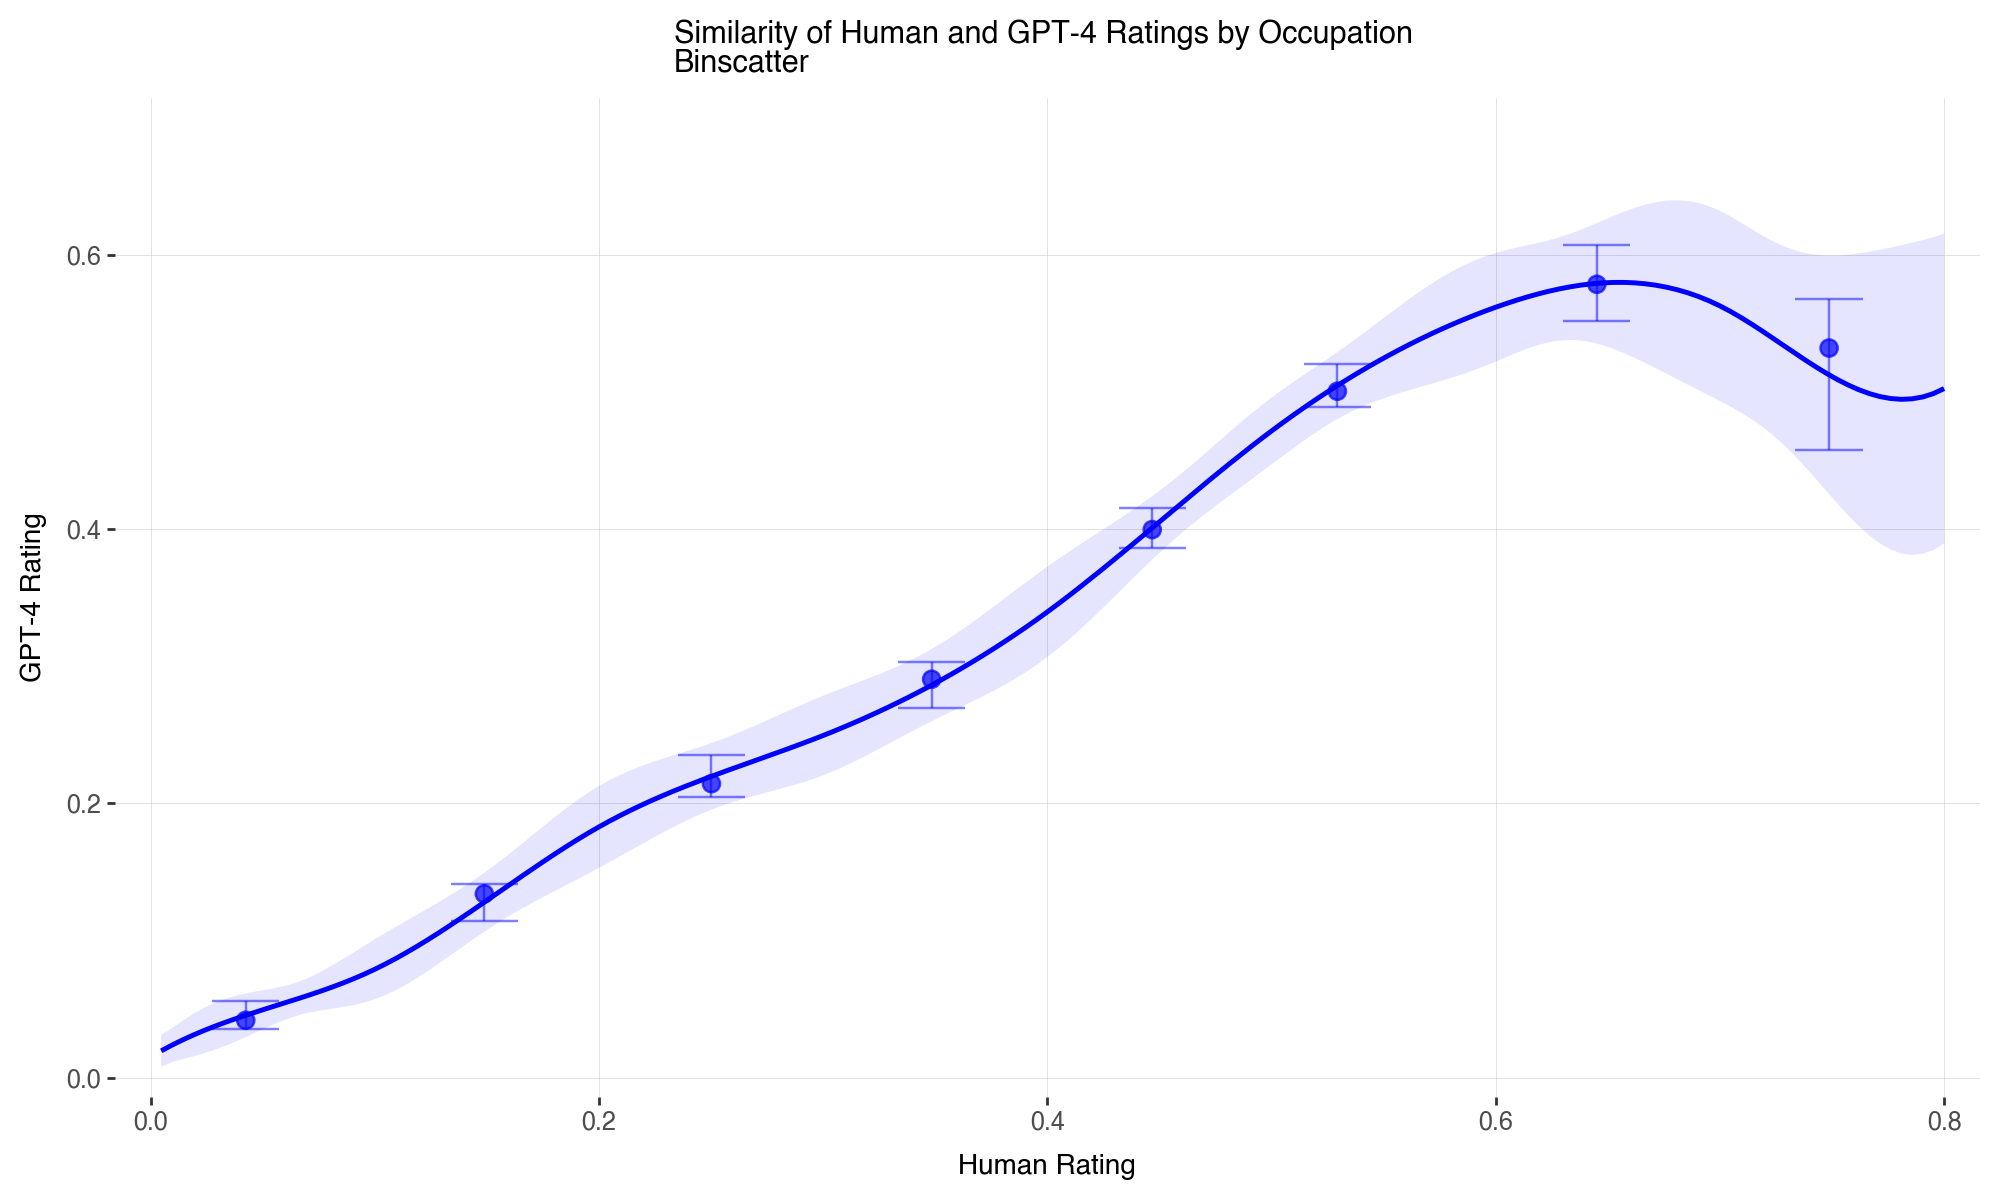

<Figure size 1000x600 with 0 Axes>

In [194]:

## Human ratings vs. GPT-4 ratings
'''
generate_binscatter(
    "human_beta",
    "gpt4_beta",
    occ_level,
    "Human Rating",
    "GPT-4 Rating",
    (0, 0.8),
    (0, 0.7),
    "Similarity of Human and GPT-4 Ratings by Occupation \nBinscatter",
)
'''
# Usage:
fig = generate_binscatter(
    "human_beta",
    "gpt4_beta",
    occ_level,
    "Human Rating",
    "GPT-4 Rating",
    (0, 0.8),
    (0, 0.7),
    "Similarity of Human and GPT-4 Ratings by Occupation \nBinscatter"
)
display(fig)  # For Jupyter notebooksturn figure instead of showing/printing







##### Agreement Scores

In [195]:
from sklearn.metrics import cohen_kappa_score

# compute the Cohen's Kappa score for the model outputs and the golden labels for taxonomy 4
kappa_ = cohen_kappa_score(full_labels["human_exposure"], full_labels["gpt4_exposure"])
print(kappa_)

0.4367287243661636


In [196]:
kappa_ = cohen_kappa_score(
    full_labels["human_exposure"], full_labels["gpt4_alt_exposure"]
)
print(kappa_)

0.40955386638134095


In [197]:
kappa_ = cohen_kappa_score(
    full_labels["gpt4_exposure"], full_labels["gpt4_alt_exposure"]
)
print(kappa_)

0.6010695449736778


# Aggregate exposure

#### Merging in BLS data

In [198]:
import openpyxl
raw_bls = pd.read_excel("/Users/gabesmithline/Desktop/GPTs-are-GPTs/data/oesm21nat/national_M2021_dl.xlsx")

# character replacements. For # there needs to be a replacement at the upper end of the range per BLS.
raw_bls.replace(to_replace=["*", "**"], value=np.nan, inplace=True)
raw_bls.replace(
    to_replace=["#"], value=208000, inplace=True
)  # bigger than $208k/year gets a #.
raw_bls.replace(to_replace=",", value="", regex=True, inplace=True)

# commas and non-numeric fields
numeric_fields = [
    "TOT_EMP",
    "EMP_PRSE",
    "JOBS_1000",
    "LOC_QUOTIENT",
    "PCT_TOTAL",
    "PCT_RPT",
    "MEAN_PRSE",
] + [item for item in list(raw_bls) if (("A_" in item[0:3]) | ("H_" in item))]
for field in numeric_fields:
    raw_bls[field] = pd.to_numeric(raw_bls[field])

# merge to other occ-level stats
occ_level["OCC_CODE"] = occ_level["O*NET-SOC Code"].str.slice(start=0, stop=7)
occ_lvl = pd.merge(
    occ_level,
    raw_bls[["OCC_CODE", "TOT_EMP", "H_MEAN", "A_MEAN", "H_MEDIAN", "A_MEDIAN"]],
    how="left",
    on="OCC_CODE",
)

# calcs in logs
occ_lvl["log_A_mean"] = np.log(occ_lvl["A_MEAN"])
occ_lvl["log_totemp"] = np.log(occ_lvl["TOT_EMP"])
occ_lvl["simpleOcc"] = occ_lvl["O*NET-SOC Code"].str.slice(stop=7)

# diff calc
occ_lvl["gpt4_human_diff"] = occ_lvl["gpt4_beta"] - occ_lvl["human_beta"]

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_12941/4205486148.py:5: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_12941/4205486148.py:6: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



##### Wage and employment binscatters

<ggplot: (640 x 480)>


/Users/gabesmithline/miniconda3/envs/gpts-are-gpts/lib/python3.13/site-packages/binsreg/binsreg.py:659: UserWarning:

Confidence intervals/bands are valid when nbins is much larger than the IMSE-optimal choice. Compare your choice with the IMSE-optimal one obtained by binsregselect().

/Users/gabesmithline/miniconda3/envs/gpts-are-gpts/lib/python3.13/site-packages/plotnine/layer.py:364: PlotnineWarning:

geom_point : Removed 3 rows containing missing values.

/Users/gabesmithline/miniconda3/envs/gpts-are-gpts/lib/python3.13/site-packages/plotnine/geoms/geom_path.py:99: PlotnineWarning:

geom_path: Removed 53 rows containing missing values.

/Users/gabesmithline/miniconda3/envs/gpts-are-gpts/lib/python3.13/site-packages/plotnine/layer.py:364: PlotnineWarning:

geom_errorbar : Removed 3 rows containing missing values.



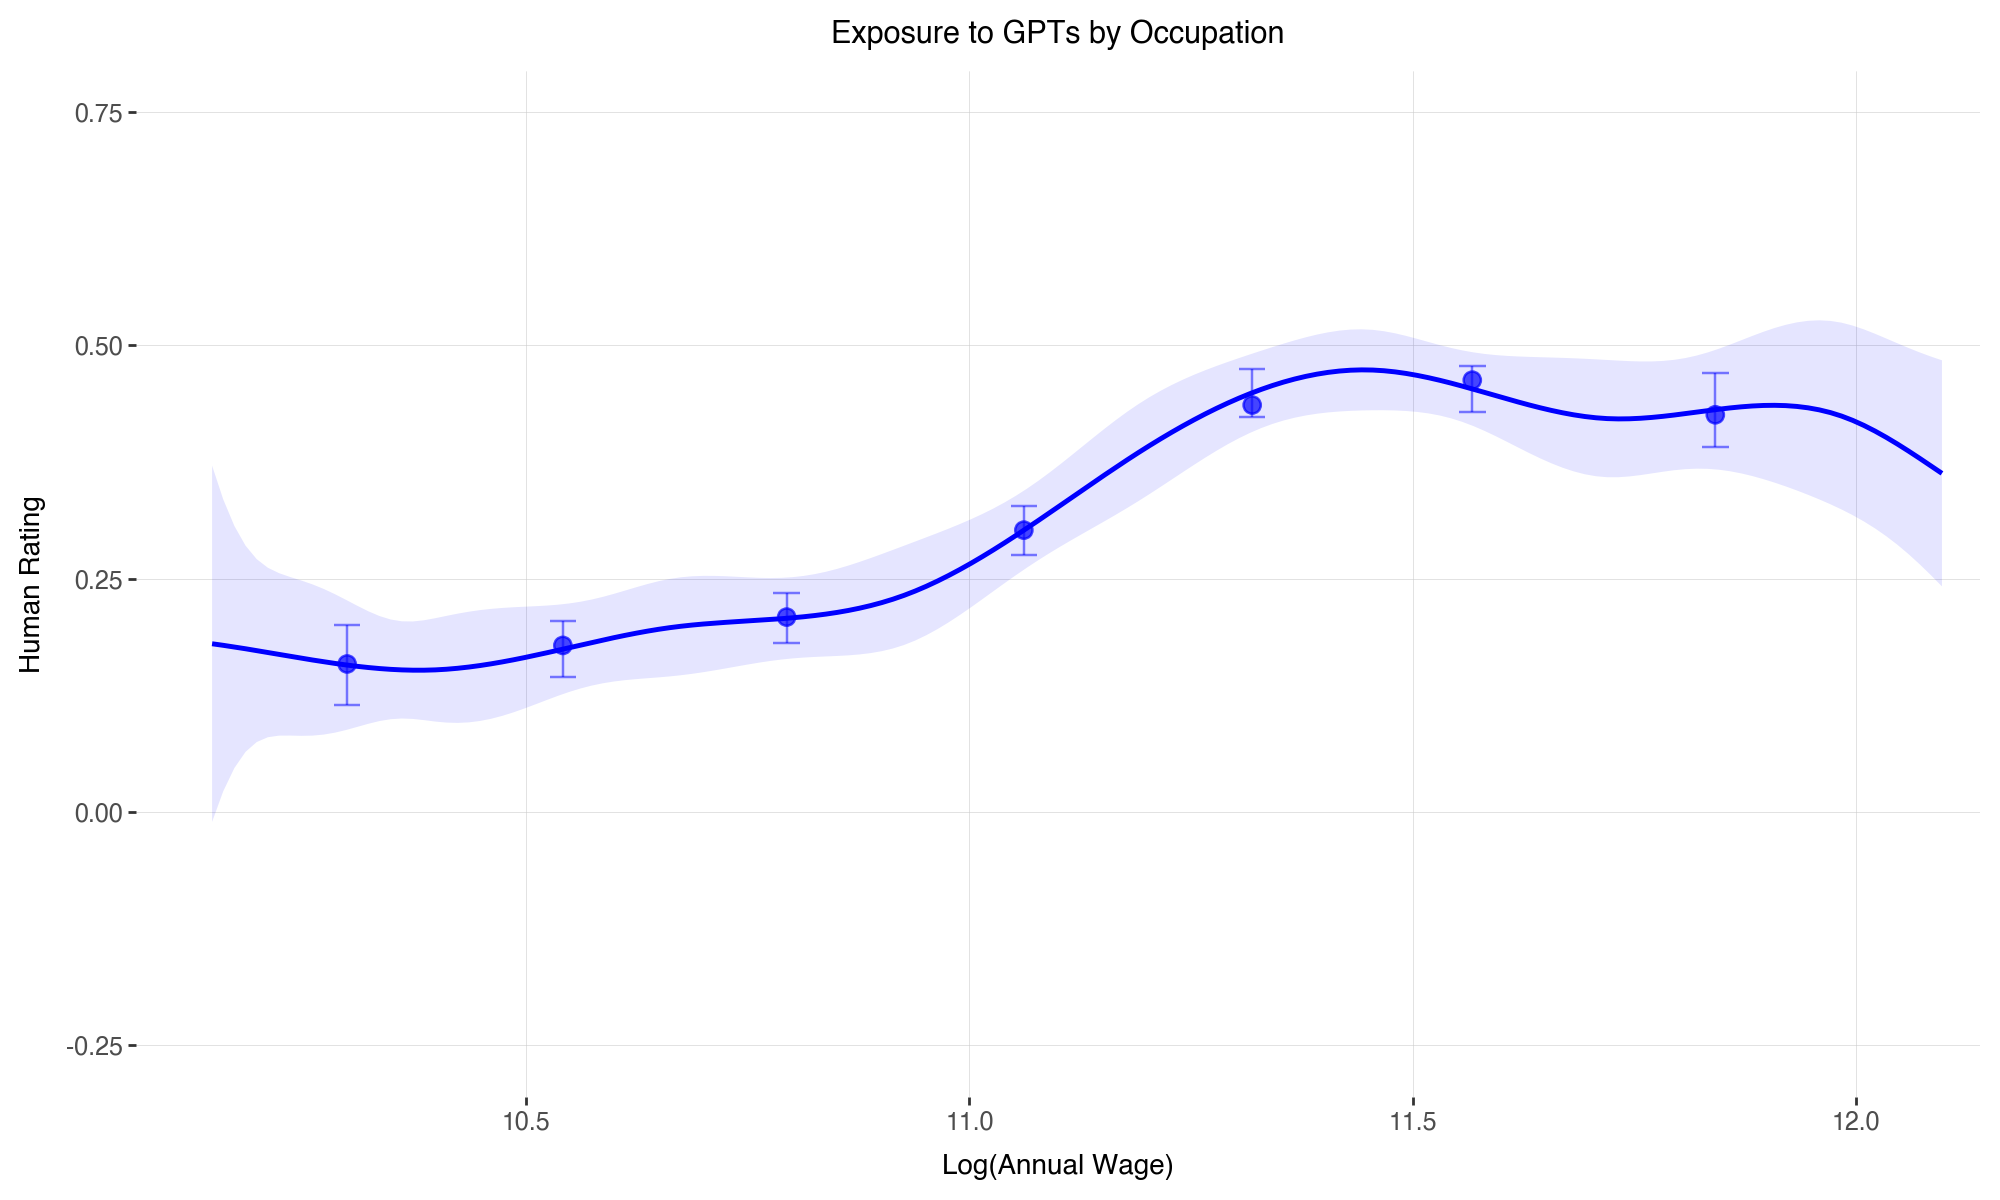

<Figure size 1000x600 with 0 Axes>

In [199]:
## wages w/human ratings
generate_binscatter(
    "human_beta",
    "log_A_mean", 
    occ_lvl,
    "Log(Annual Wage)",
    "Human Rating",
    (10.1, 12.1),
    None,
    "Exposure to GPTs by Occupation"
)

/Users/gabesmithline/miniconda3/envs/gpts-are-gpts/lib/python3.13/site-packages/binsreg/binsreg.py:659: UserWarning:

Confidence intervals/bands are valid when nbins is much larger than the IMSE-optimal choice. Compare your choice with the IMSE-optimal one obtained by binsregselect().

/Users/gabesmithline/miniconda3/envs/gpts-are-gpts/lib/python3.13/site-packages/plotnine/layer.py:364: PlotnineWarning:

geom_point : Removed 3 rows containing missing values.

/Users/gabesmithline/miniconda3/envs/gpts-are-gpts/lib/python3.13/site-packages/plotnine/geoms/geom_path.py:99: PlotnineWarning:

geom_path: Removed 53 rows containing missing values.

/Users/gabesmithline/miniconda3/envs/gpts-are-gpts/lib/python3.13/site-packages/plotnine/layer.py:364: PlotnineWarning:

geom_errorbar : Removed 3 rows containing missing values.



<ggplot: (640 x 480)>


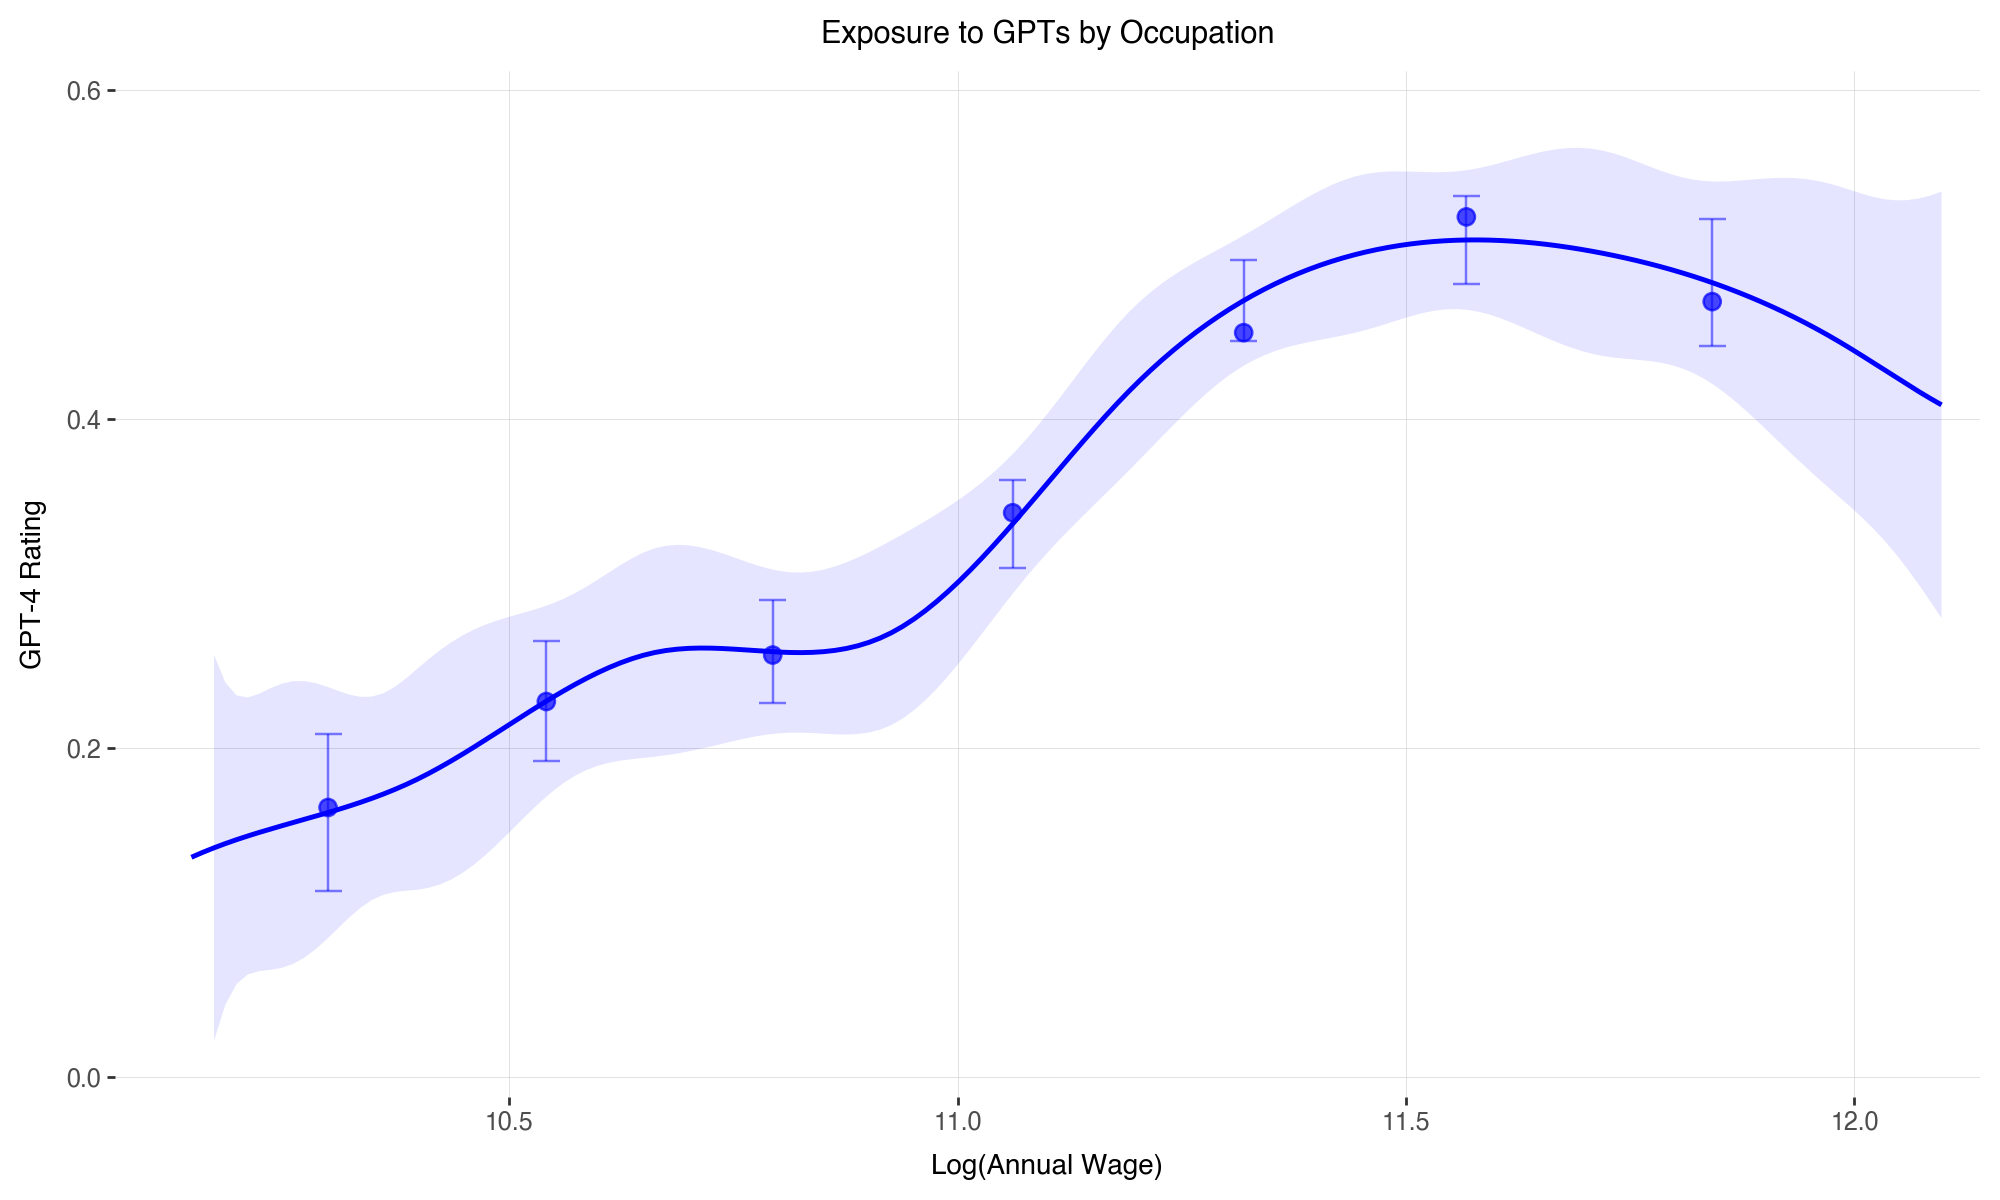

<Figure size 1000x600 with 0 Axes>

In [200]:
## wages and GPT-4 ratings
generate_binscatter(
    "gpt4_beta",
    "log_A_mean",
    occ_lvl,
    "Log(Annual Wage)",
    "GPT-4 Rating",
    (10.1, 12.1),
    (0, 0.6),
    "Exposure to GPTs by Occupation",
)

/Users/gabesmithline/miniconda3/envs/gpts-are-gpts/lib/python3.13/site-packages/binsreg/binsreg.py:659: UserWarning:

Confidence intervals/bands are valid when nbins is much larger than the IMSE-optimal choice. Compare your choice with the IMSE-optimal one obtained by binsregselect().

/Users/gabesmithline/miniconda3/envs/gpts-are-gpts/lib/python3.13/site-packages/plotnine/layer.py:364: PlotnineWarning:

geom_point : Removed 3 rows containing missing values.

/Users/gabesmithline/miniconda3/envs/gpts-are-gpts/lib/python3.13/site-packages/plotnine/geoms/geom_path.py:99: PlotnineWarning:

geom_path: Removed 53 rows containing missing values.

/Users/gabesmithline/miniconda3/envs/gpts-are-gpts/lib/python3.13/site-packages/plotnine/layer.py:364: PlotnineWarning:

geom_errorbar : Removed 3 rows containing missing values.



<ggplot: (640 x 480)>


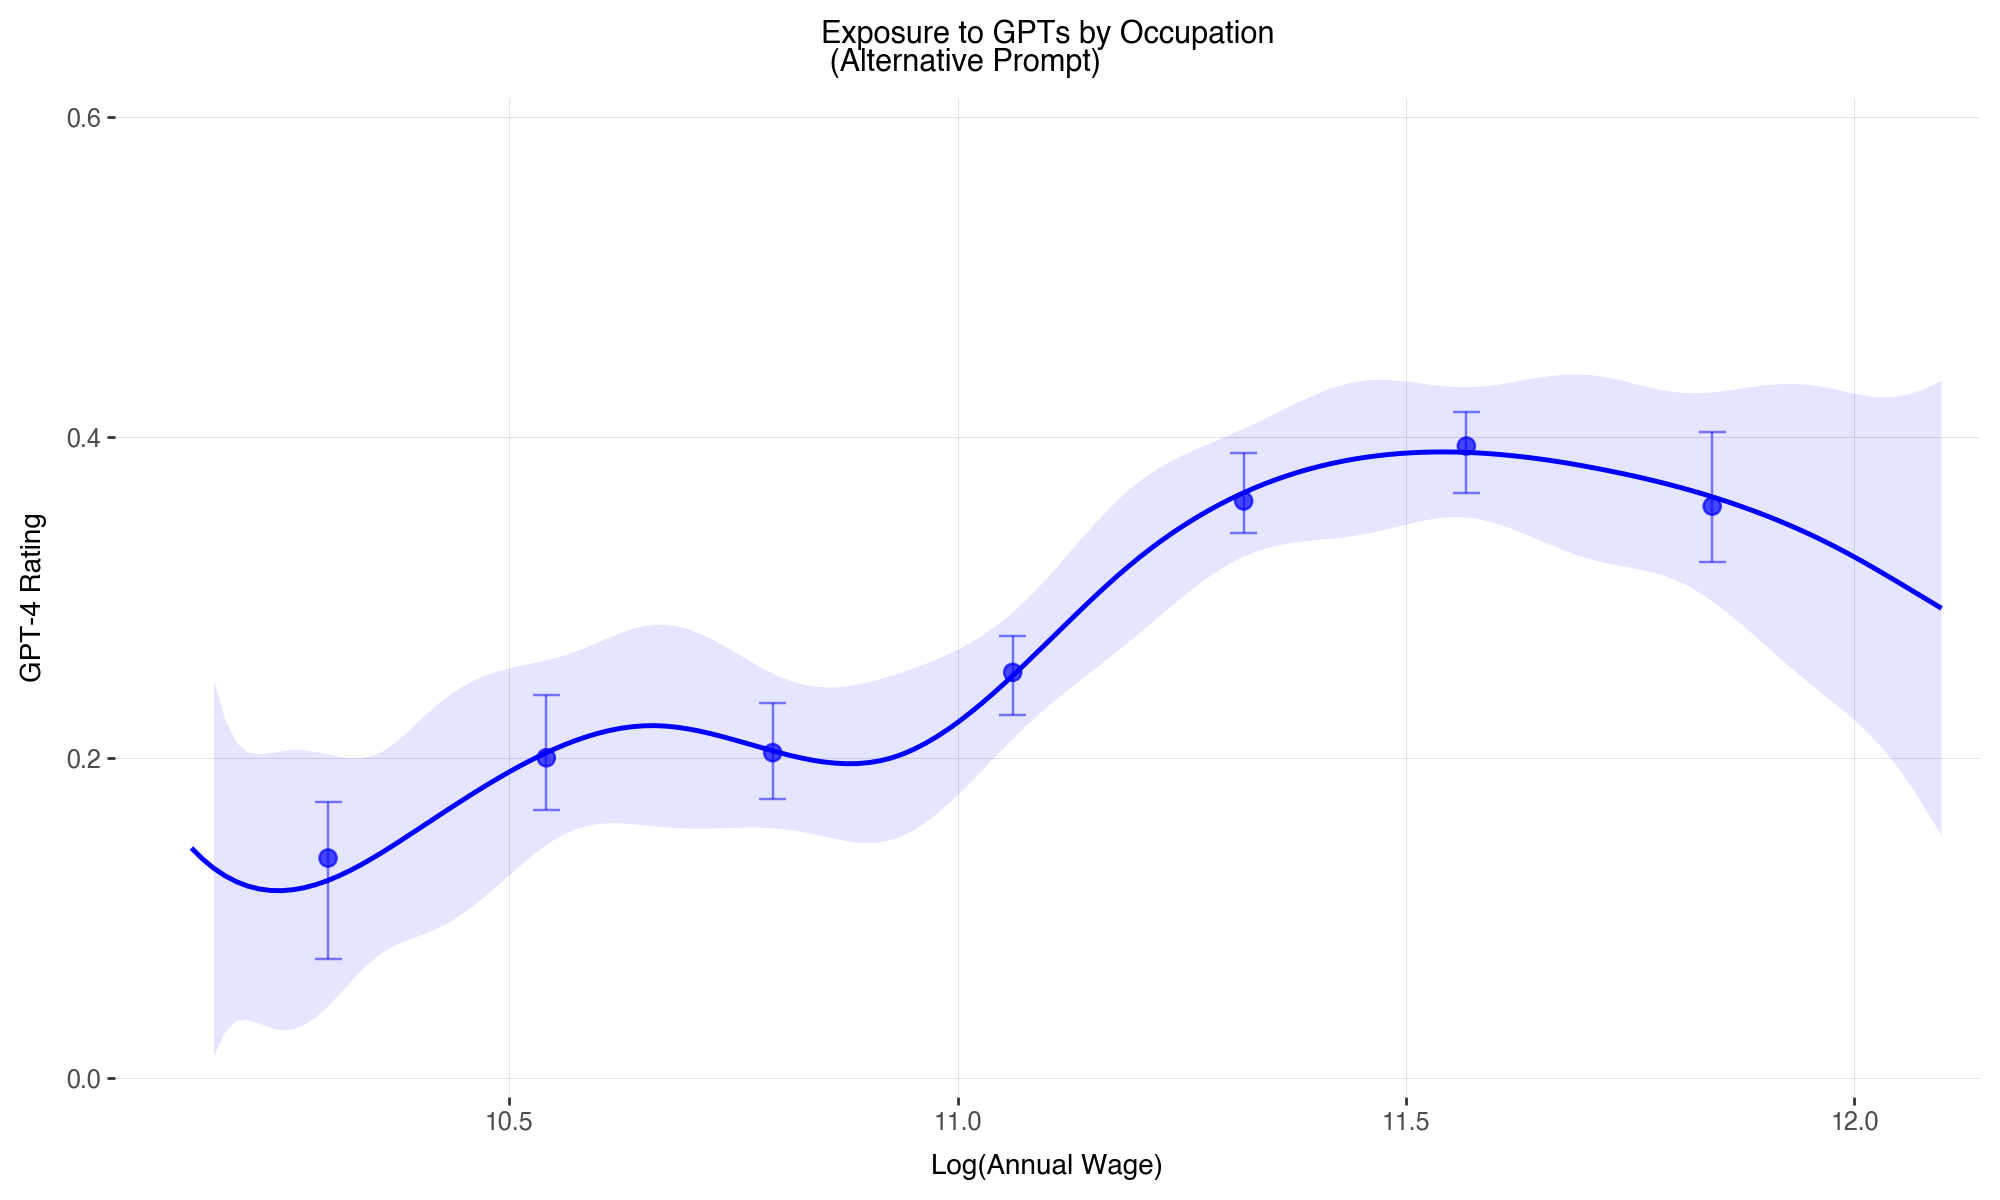

<Figure size 1000x600 with 0 Axes>

In [201]:
## wages and GPT-4 rubric 2 ratings
generate_binscatter(
    "gpt4_alt_beta",
    "log_A_mean",
    occ_lvl,
    "Log(Annual Wage)",
    "GPT-4 Rating",
    (10.1, 12.1),
    (0, 0.6),
    "Exposure to GPTs by Occupation\n (Alternative Prompt)",
)

/Users/gabesmithline/miniconda3/envs/gpts-are-gpts/lib/python3.13/site-packages/binsreg/binsreg.py:659: UserWarning:

Confidence intervals/bands are valid when nbins is much larger than the IMSE-optimal choice. Compare your choice with the IMSE-optimal one obtained by binsregselect().

/Users/gabesmithline/miniconda3/envs/gpts-are-gpts/lib/python3.13/site-packages/plotnine/layer.py:364: PlotnineWarning:

geom_point : Removed 3 rows containing missing values.

/Users/gabesmithline/miniconda3/envs/gpts-are-gpts/lib/python3.13/site-packages/plotnine/geoms/geom_path.py:99: PlotnineWarning:

geom_path: Removed 53 rows containing missing values.

/Users/gabesmithline/miniconda3/envs/gpts-are-gpts/lib/python3.13/site-packages/plotnine/layer.py:364: PlotnineWarning:

geom_errorbar : Removed 3 rows containing missing values.



<ggplot: (640 x 480)>


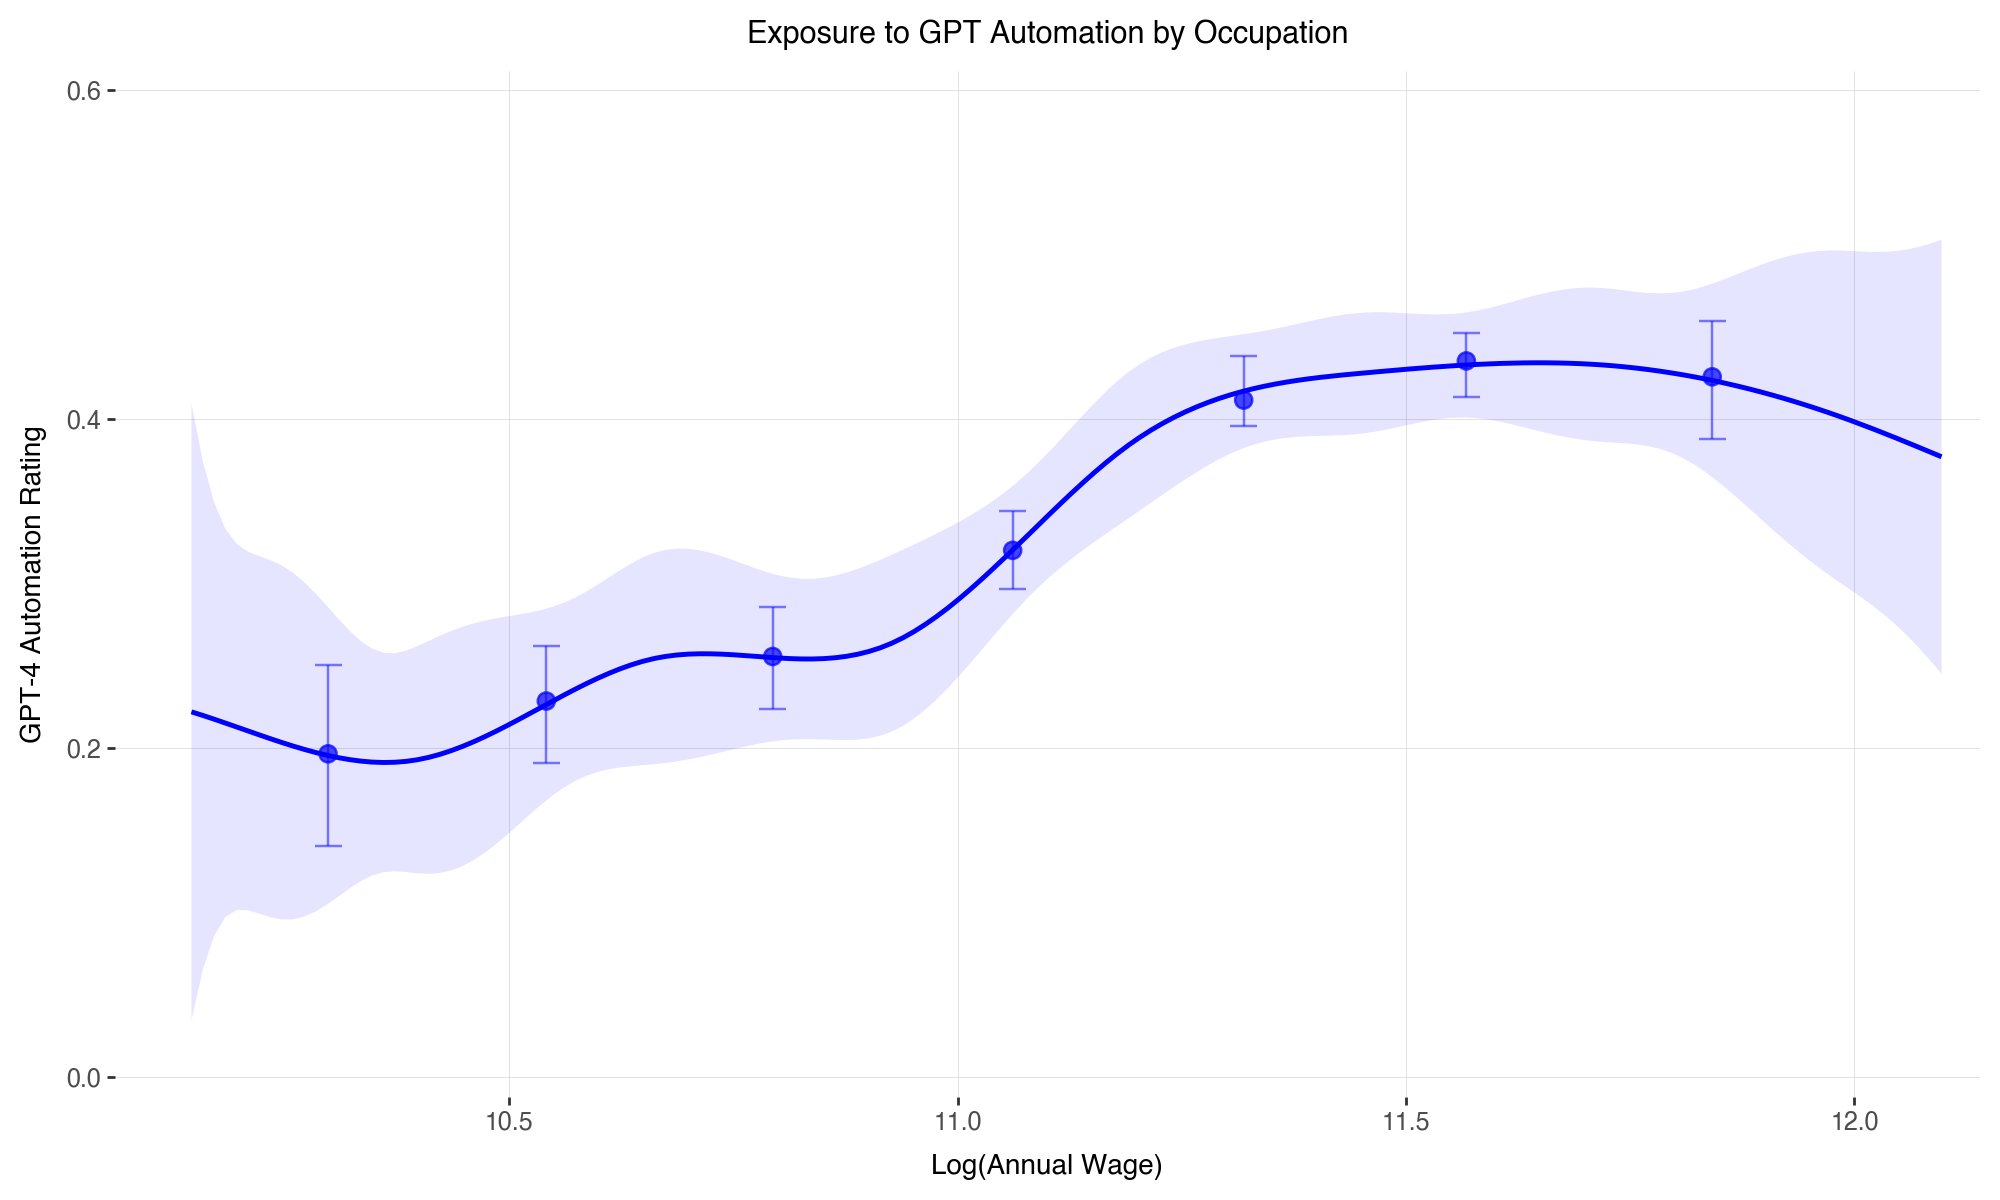

<Figure size 1000x600 with 0 Axes>

In [202]:
## wages and automation
generate_binscatter(
    "automation",
    "log_A_mean",
    occ_lvl,
    "Log(Annual Wage)",
    "GPT-4 Automation Rating",
    (10.1, 12.1),
    (0, 0.6),
    "Exposure to GPT Automation by Occupation",
)

/Users/gabesmithline/miniconda3/envs/gpts-are-gpts/lib/python3.13/site-packages/binsreg/binsreg.py:659: UserWarning:

Confidence intervals/bands are valid when nbins is much larger than the IMSE-optimal choice. Compare your choice with the IMSE-optimal one obtained by binsregselect().

/Users/gabesmithline/miniconda3/envs/gpts-are-gpts/lib/python3.13/site-packages/plotnine/layer.py:364: PlotnineWarning:

geom_point : Removed 3 rows containing missing values.

/Users/gabesmithline/miniconda3/envs/gpts-are-gpts/lib/python3.13/site-packages/plotnine/geoms/geom_path.py:99: PlotnineWarning:

geom_path: Removed 70 rows containing missing values.

/Users/gabesmithline/miniconda3/envs/gpts-are-gpts/lib/python3.13/site-packages/plotnine/layer.py:364: PlotnineWarning:

geom_errorbar : Removed 3 rows containing missing values.



<ggplot: (640 x 480)>


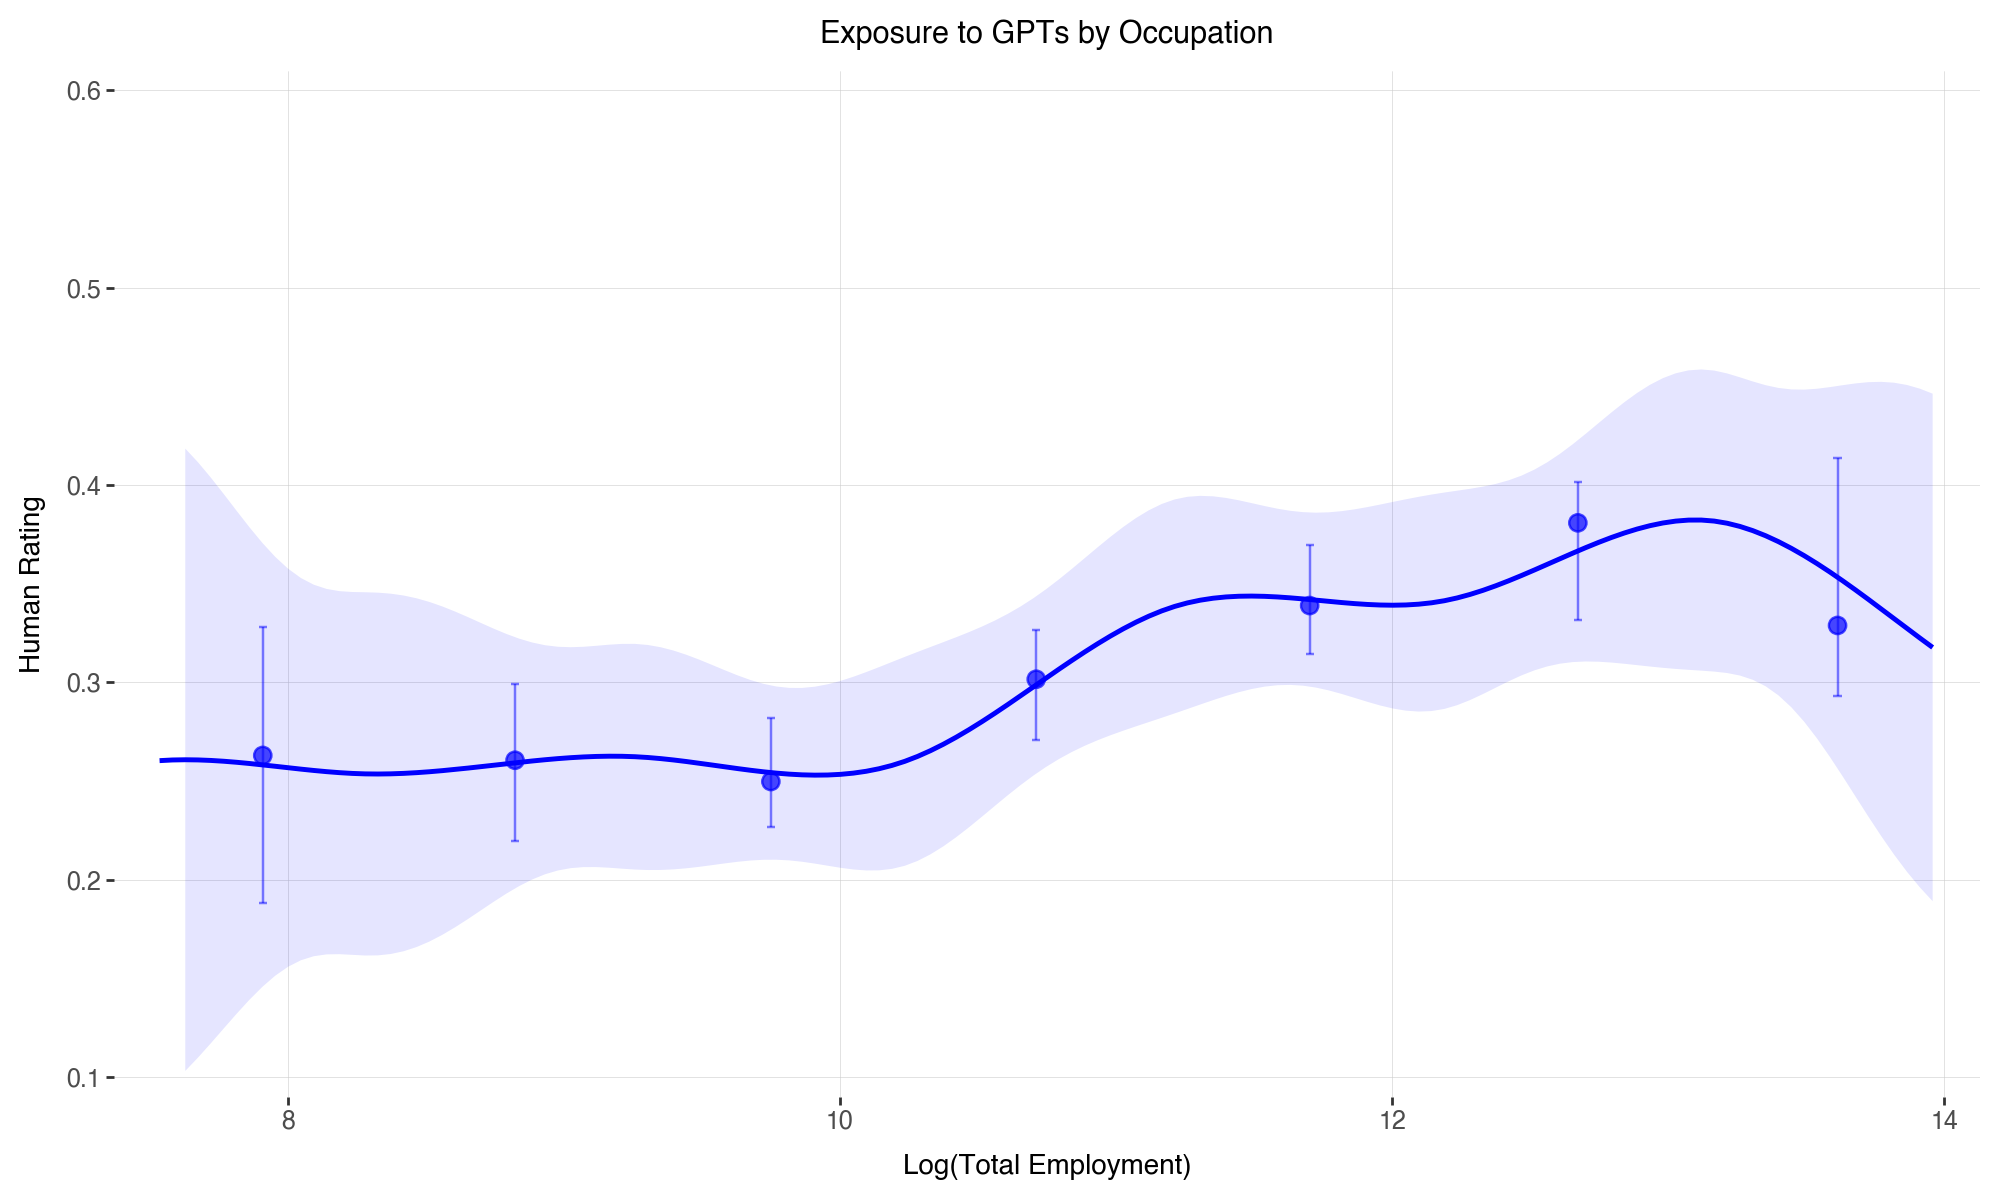

<Figure size 1000x600 with 0 Axes>

In [203]:
## employment and human ratings
generate_binscatter(
    "human_beta",
    "log_totemp",
    occ_lvl,
    "Log(Total Employment)",
    "Human Rating",
    (7.5, 14),
    (0.1, 0.6),
    "Exposure to GPTs by Occupation",
)

/Users/gabesmithline/miniconda3/envs/gpts-are-gpts/lib/python3.13/site-packages/binsreg/binsreg.py:659: UserWarning:

Confidence intervals/bands are valid when nbins is much larger than the IMSE-optimal choice. Compare your choice with the IMSE-optimal one obtained by binsregselect().

/Users/gabesmithline/miniconda3/envs/gpts-are-gpts/lib/python3.13/site-packages/plotnine/layer.py:364: PlotnineWarning:

geom_point : Removed 3 rows containing missing values.

/Users/gabesmithline/miniconda3/envs/gpts-are-gpts/lib/python3.13/site-packages/plotnine/geoms/geom_path.py:99: PlotnineWarning:

geom_path: Removed 70 rows containing missing values.

/Users/gabesmithline/miniconda3/envs/gpts-are-gpts/lib/python3.13/site-packages/plotnine/layer.py:364: PlotnineWarning:

geom_errorbar : Removed 3 rows containing missing values.



<ggplot: (640 x 480)>


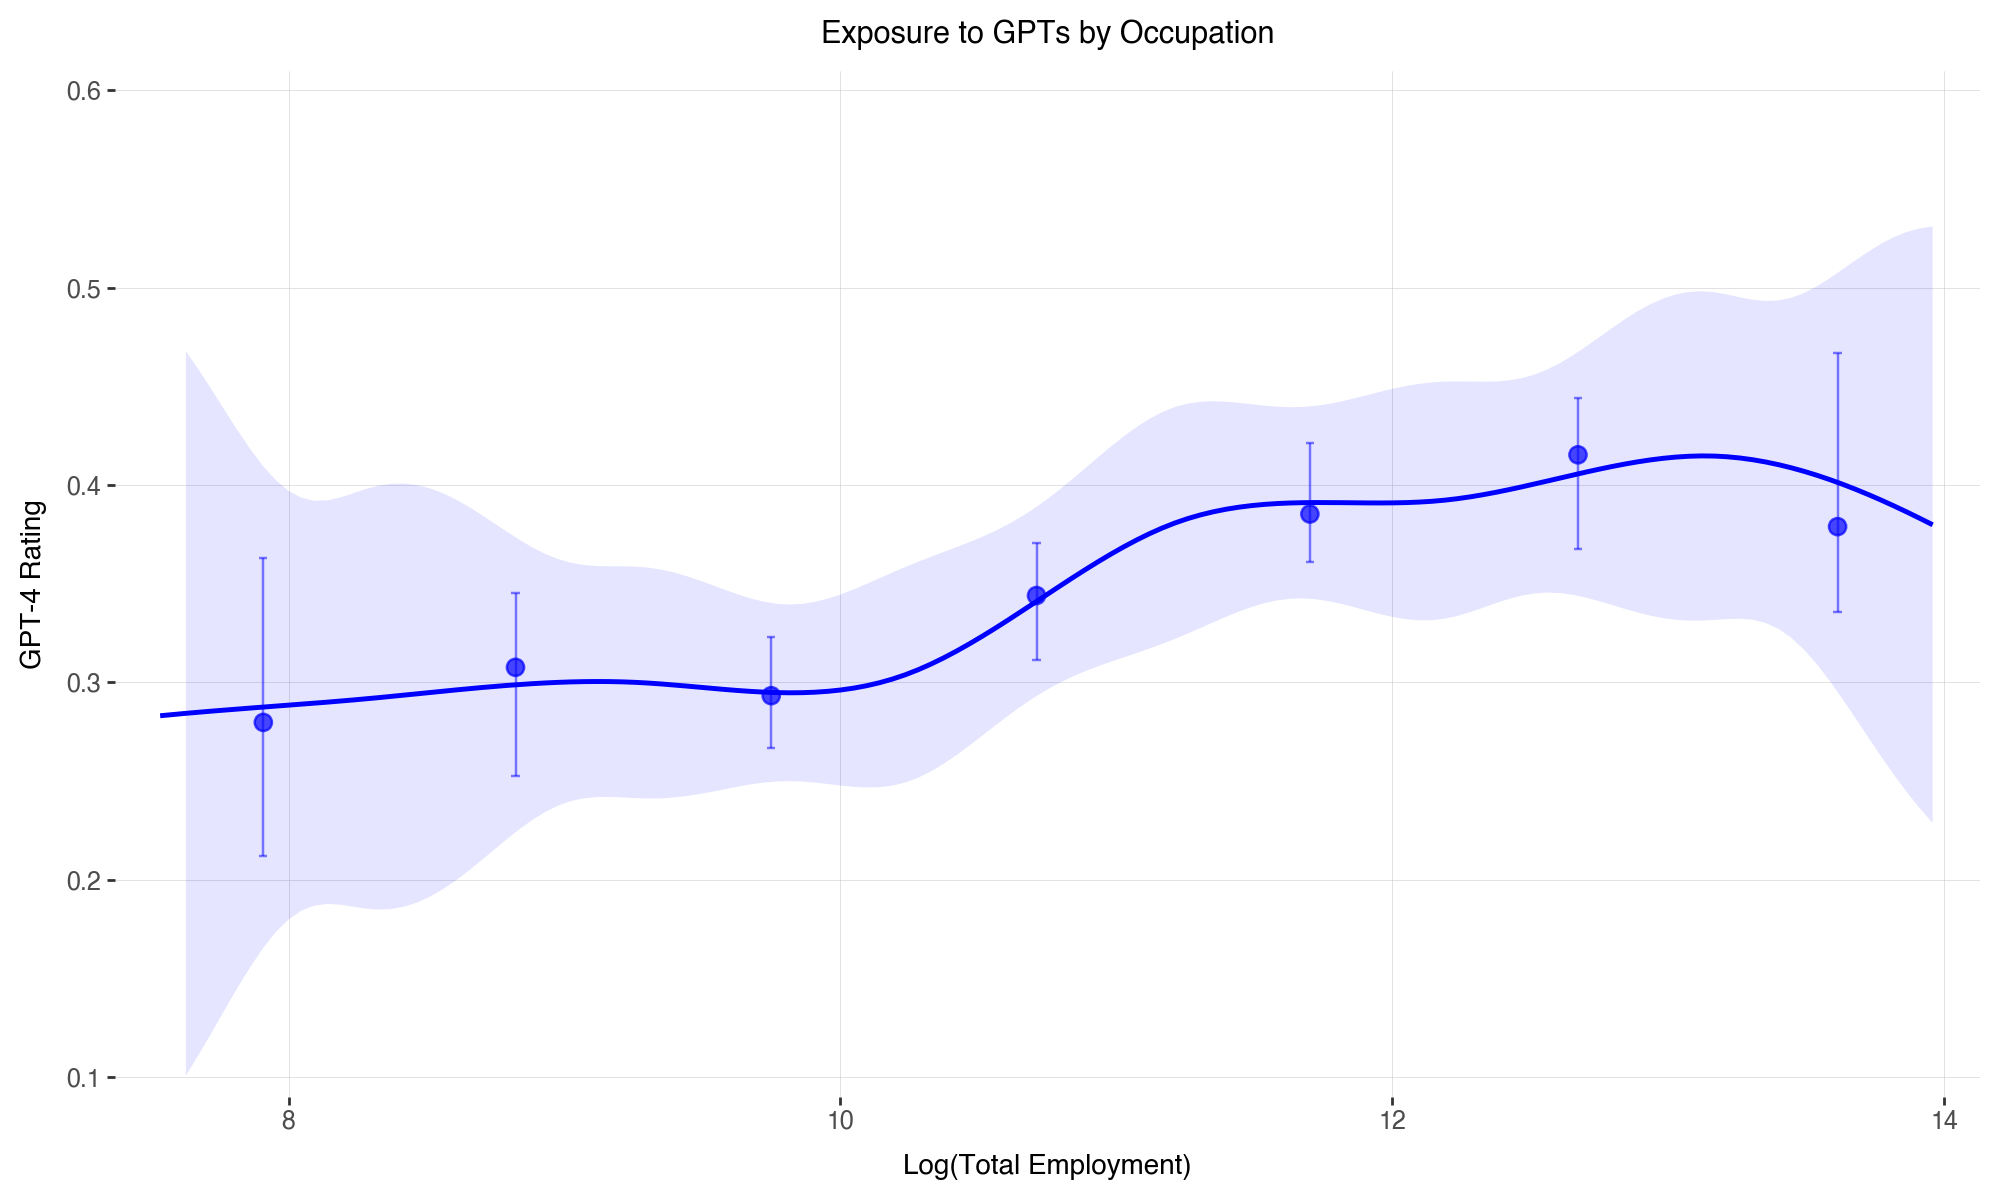

<Figure size 1000x600 with 0 Axes>

In [204]:
## employment and GPT-4 rubric 1 ratings
generate_binscatter(
    "gpt4_beta",
    "log_totemp",
    occ_lvl,
    "Log(Total Employment)",
    "GPT-4 Rating",
    (7.5, 14),
    (0.1, 0.6),
    "Exposure to GPTs by Occupation",
)

# Industry-level analyses

In [205]:
## need to first compile industry datasets

def proc_ind_file(file_in):
    """sets up basics for industry df but doesn't do calculations yet"""
    
    ind_df = pd.read_excel(file_in)
    # character replacements
    ind_df.replace(to_replace=["*", "**"], value=np.nan, inplace=True)
    ind_df.replace(
        to_replace=["#"], value=208000, inplace=True
    )  # bigger than $208k/year gets a #.
    ind_df.replace(to_replace=",", value="", regex=True, inplace=True)

    # commas and non-numeric fields
    numeric_fields = [
        "TOT_EMP",
        "EMP_PRSE",
        "JOBS_1000",
        "LOC_QUOTIENT",
        "PCT_TOTAL",
        "MEAN_PRSE",
    ] + [item for item in list(ind_df) if (("A_" in item[0:3]) | ("H_" in item))]
    for field in numeric_fields:
        ind_df[field] = pd.to_numeric(ind_df[field])
    ind_df_det = ind_df[
        ind_df["O_GROUP"] == "detailed"
    ].copy()  # only the detailed occupations
    return ind_df, ind_df_det


def empWeightCalc(ind_df_det):
    ind_emp_sums = (
        ind_df_det[["NAICS", "TOT_EMP"]].groupby("NAICS").sum().reset_index()
    )  # total employment by industry using detailed job groups
    ind_emp_sums.rename(columns={"TOT_EMP": "IND_EMP"}, inplace=True)
    ind_df_det = pd.merge(
        ind_df_det, ind_emp_sums, how="left", on="NAICS"
    )  # merge to ind_df_det
    ind_df_det["empWeight"] = (
        ind_df_det["TOT_EMP"] / ind_df_det["IND_EMP"]
    )  # calculates each row weight
    return ind_df_det


# NAICS 2
ind_df_2, ind_df_det_2 = proc_ind_file(
    "../data/oesm21in4/natsector_M2021_dl.xlsx"
)
ind_df_det_2 = empWeightCalc(ind_df_det_2)

# NAICS 3
ind_df_3, ind_df_det_3 = proc_ind_file("../data/oesm21in4/nat3d_M2021_dl.xlsx")
ind_df_det_3 = empWeightCalc(ind_df_det_3)

# NAICS 4
ind_df_4, ind_df_det_4 = proc_ind_file("../data/oesm21in4/nat4d_M2021_dl.xlsx")
ind_df_det_4 = empWeightCalc(ind_df_det_4)

print(ind_df_3.shape, ind_df_det_3.shape)
ind_df_det_3.head(10)

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_12941/630328782.py:8: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_12941/630328782.py:9: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_12941/630328782.py:8: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the

(38720, 32) (18417, 34)


,AREA,AREA_TITLE,AREA_TYPE,PRIM_STATE,NAICS,NAICS_TITLE,I_GROUP,OWN_CODE,OCC_CODE,OCC_TITLE,...,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,ANNUAL,HOURLY,IND_EMP,empWeight
0,99,U.S.,1,US,113000,Forestry and Logging,3-digit,5,11-1021,General and Operations Managers,...,208000.00,48610.0,76880.0,121980.0,129620.0,208000.0,NaN,NaN,45380.0,0.014544
1,99,U.S.,1,US,113000,Forestry and Logging,3-digit,5,11-9199,Managers All Other,...,208000.00,59400.0,77040.0,120130.0,165520.0,208000.0,NaN,NaN,45380.0,NaN
2,99,U.S.,1,US,113000,Forestry and Logging,3-digit,5,13-1020,Buyers and Purchasing Agents,...,58.56,36940.0,38670.0,49250.0,80260.0,121790.0,NaN,NaN,45380.0,NaN
3,99,U.S.,1,US,113000,Forestry and Logging,3-digit,5,13-1199,Business Operations Specialists All Other,...,61.45,47140.0,49790.0,65390.0,102660.0,127820.0,NaN,NaN,45380.0,NaN
4,99,U.S.,1,US,113000,Forestry and Logging,3-digit,5,13-2011,Accountants and Auditors,...,47.13,47330.0,57660.0,75000.0,76710.0,98020.0,NaN,NaN,45380.0,NaN
5,99,U.S.,1,US,113000,Forestry and Logging,3-digit,5,19-1032,Foresters,...,48.38,47470.0,59240.0,74700.0,97390.0,100620.0,NaN,NaN,45380.0,0.019392
6,99,U.S.,1,US,113000,Forestry and Logging,3-digit,5,33-9032,Security Guards,...,15.87,27790.0,28570.0,28940.0,30050.0,33010.0,NaN,NaN,45380.0,0.002865
7,99,U.S.,1,US,113000,Forestry and Logging,3-digit,5,37-2011,Janitors and Cleaners Except Maids and Houseke...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45380.0,0.003085
8,99,U.S.,1,US,113000,Forestry and Logging,3-digit,5,37-3013,Tree Trimmers and Pruners,...,29.20,30590.0,38270.0,48240.0,50040.0,60730.0,NaN,NaN,45380.0,0.002644
9,99,U.S.,1,US,113000,Forestry and Logging,3-digit,5,41-4012,Sales Representatives Wholesale and Manufactur...,...,65.24,57170.0,57170.0,59930.0,65220.0,135700.0,NaN,NaN,45380.0,0.001763


In [206]:
# get 6 digit SOC means before employment weighting
scores_fields_and_id = [
    "simpleOcc",
    "gpt_relevant",
    "human_beta",
    "gpt4_beta",
    "gpt4_alt_beta",
    "automation",
    "gpt4_human_diff",
]
occ_lvl_ind = (
    occ_lvl[[item for item in occ_lvl if item in scores_fields_and_id]]
    .groupby("simpleOcc")
    .mean()
    .reset_index()
)

## merge to industry data
ind_df_2_scores = pd.merge(
    ind_df_det_2, occ_lvl_ind, how="left", left_on="OCC_CODE", right_on="simpleOcc"
)
ind_df_3_scores = pd.merge(
    ind_df_det_3, occ_lvl_ind, how="left", left_on="OCC_CODE", right_on="simpleOcc"
)
ind_df_4_scores = pd.merge(
    ind_df_det_4, occ_lvl_ind, how="left", left_on="OCC_CODE", right_on="simpleOcc"
)

In [207]:
## use employment weights to get the NAICS-level exposure scores (using GPT-4 rubric 1 here)


def score_by_ind(ind_df, score_in):
    temp_ind = ind_df[["NAICS", "NAICS_TITLE", "empWeight", score_in]].copy()
    temp_ind[score_in] = temp_ind[score_in] * temp_ind["empWeight"]
    return (
        temp_ind[["NAICS", "NAICS_TITLE", score_in]]
        .groupby(["NAICS", "NAICS_TITLE"])
        .sum()
        .reset_index()
    )


dv3_ind_2 = pd.merge(
    score_by_ind(ind_df_2_scores, "gpt4_beta"),
    ind_df_2_scores[["NAICS", "IND_EMP"]].drop_duplicates(),
    how="left",
    on="NAICS",
)
dv3_ind_2.sort_values(by="gpt4_beta", ascending=False)

dv3_ind_3 = pd.merge(
    score_by_ind(ind_df_3_scores, "gpt4_beta"),
    ind_df_3_scores[["NAICS", "IND_EMP"]].drop_duplicates(),
    how="left",
    on="NAICS",
)
dv3_ind_3.sort_values(by="gpt4_beta", ascending=False)

dv3_ind_4 = pd.merge(
    score_by_ind(ind_df_4_scores, "gpt4_beta"),
    ind_df_4_scores[["NAICS", "IND_EMP"]].drop_duplicates(),
    how="left",
    on="NAICS",
)
dv3_ind_4.sort_values(by="gpt4_beta", ascending=False)

,NAICS,NAICS_TITLE,gpt4_beta,IND_EMP
153,511200,Software Publishers,0.658241,520110.0
177,541500,Computer Systems Design and Related Services,0.653542,2247510.0
159,518200,Data Processing Hosting and Related Services,0.634620,368810.0
160,519100,Other Information Services,0.626650,356520.0
186,561400,Business Support Services,0.594070,810310.0
...,...,...,...,...
206,621600,Home Health Care Services,0.151818,1510580.0
215,624100,Individual and Family Services,0.121351,2635170.0
26,311600,Animal Slaughtering and Processing,0.117533,518230.0
189,561700,Services to Buildings and Dwellings,0.114717,2119800.0


/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_12941/3000209388.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




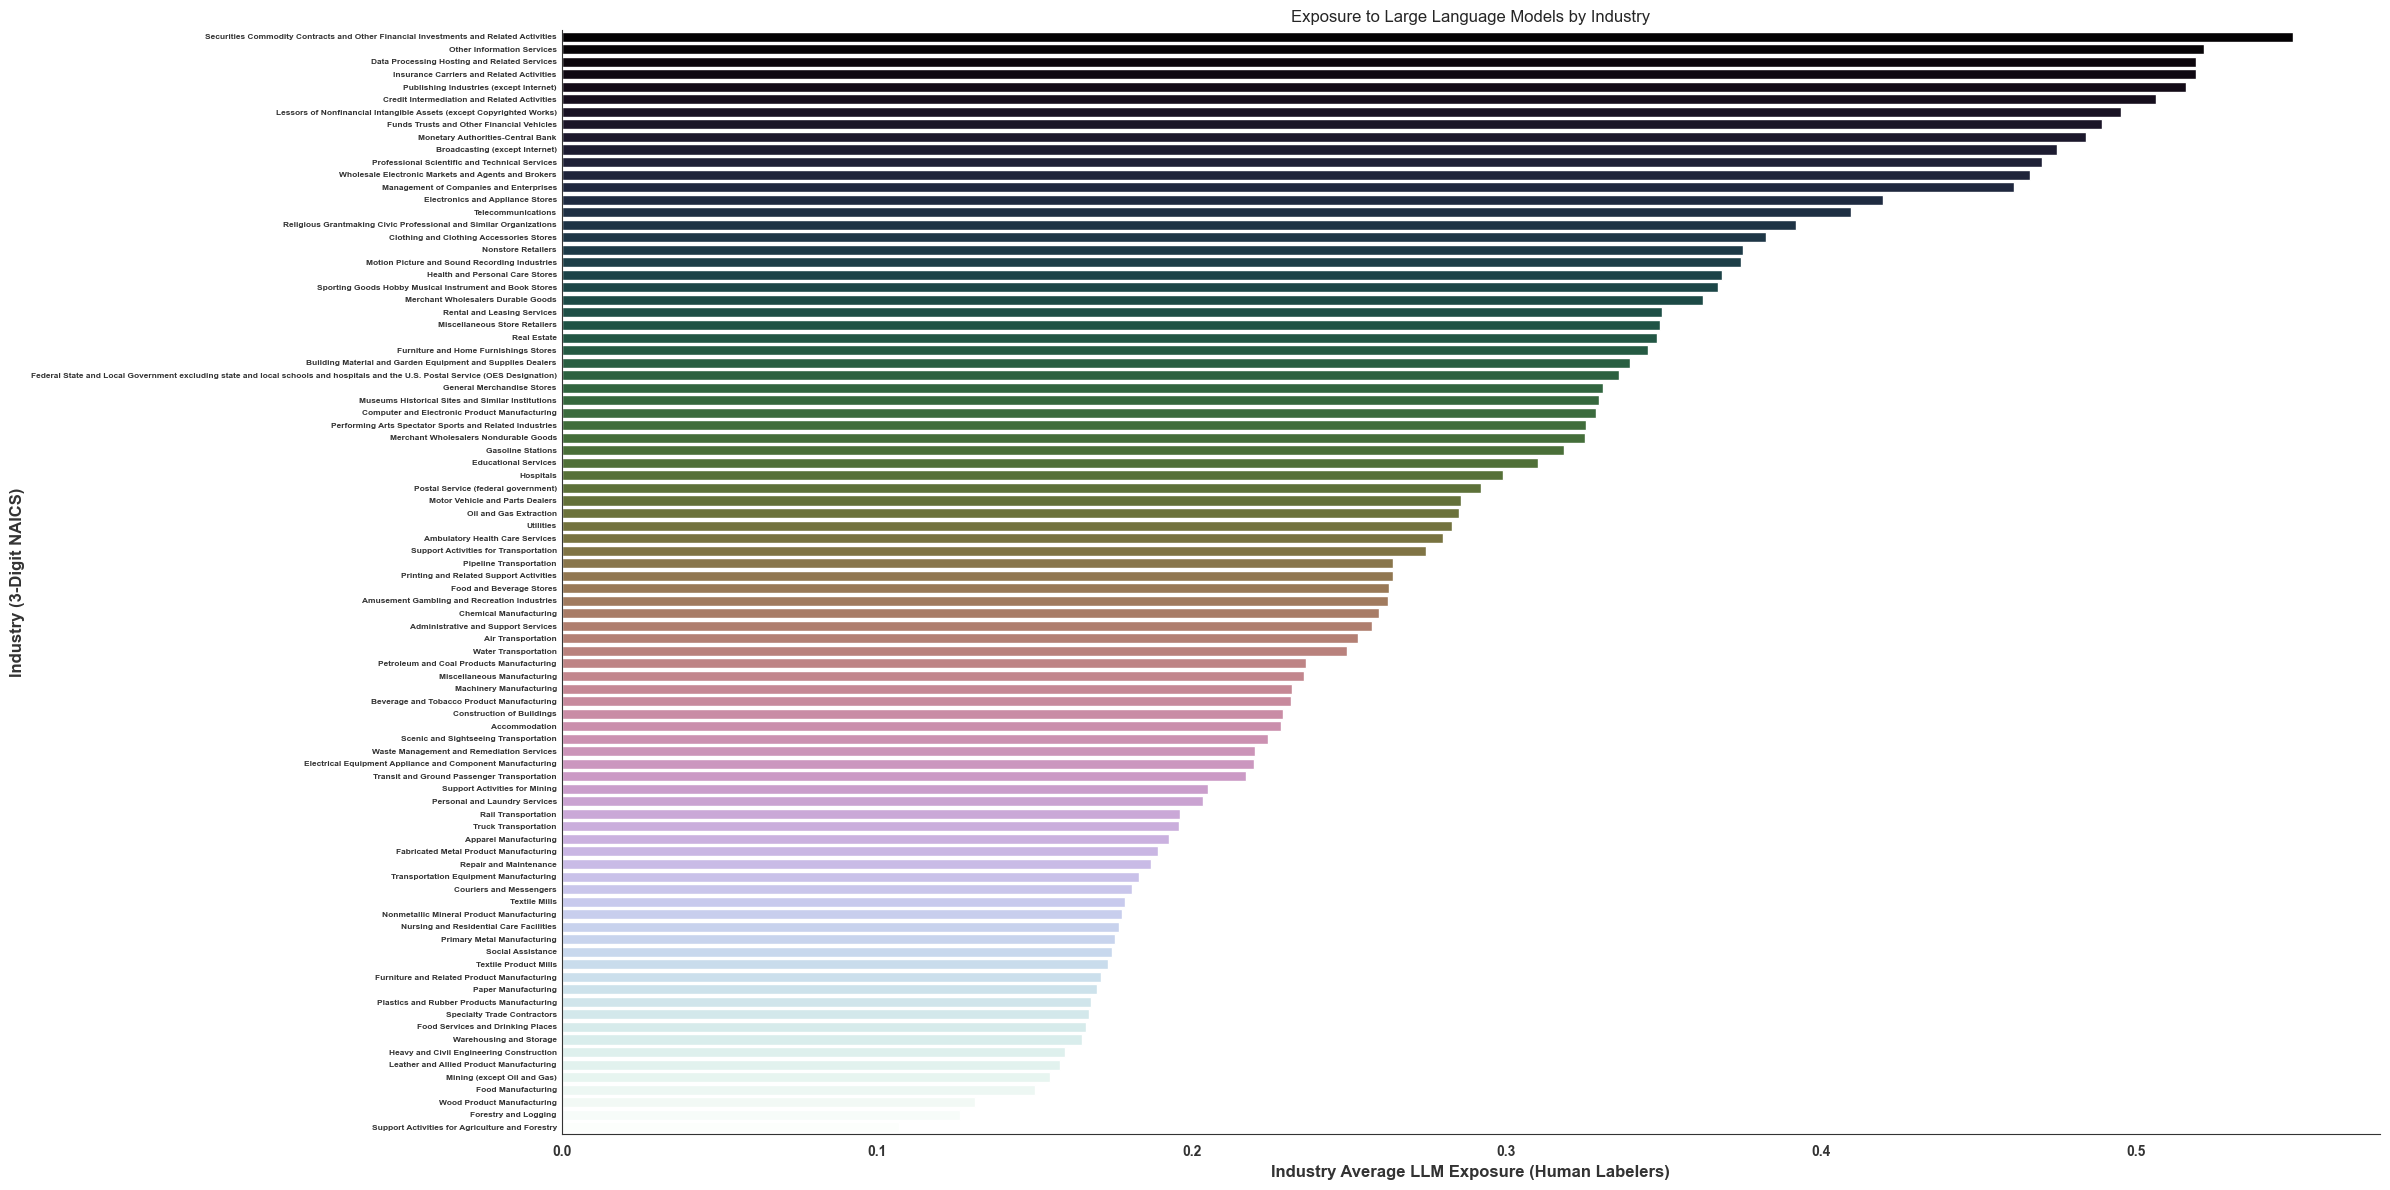

In [208]:
## Industry exposure plot for human ratings
oai_ind = score_by_ind(ind_df_3_scores, "human_beta")
sorted_oai_ind = oai_ind.sort_values(by="human_beta", ascending=False)

fig, ax = plt.subplots(figsize=(24, 12))
sns.barplot(
    data=sorted_oai_ind, y="NAICS_TITLE", x="human_beta", palette="cubehelix", ax=ax
)
ax.grid(axis="x")
ax.tick_params(axis="y", labelsize=6)
ax.set_xlabel("Industry Average LLM Exposure (Human Labelers)")
ax.set_ylabel("Industry (3-Digit NAICS)")
ax.set_title("Exposure to Large Language Models by Industry")
sns.despine()
plt.tight_layout()
plt.show()

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_12941/1647856052.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




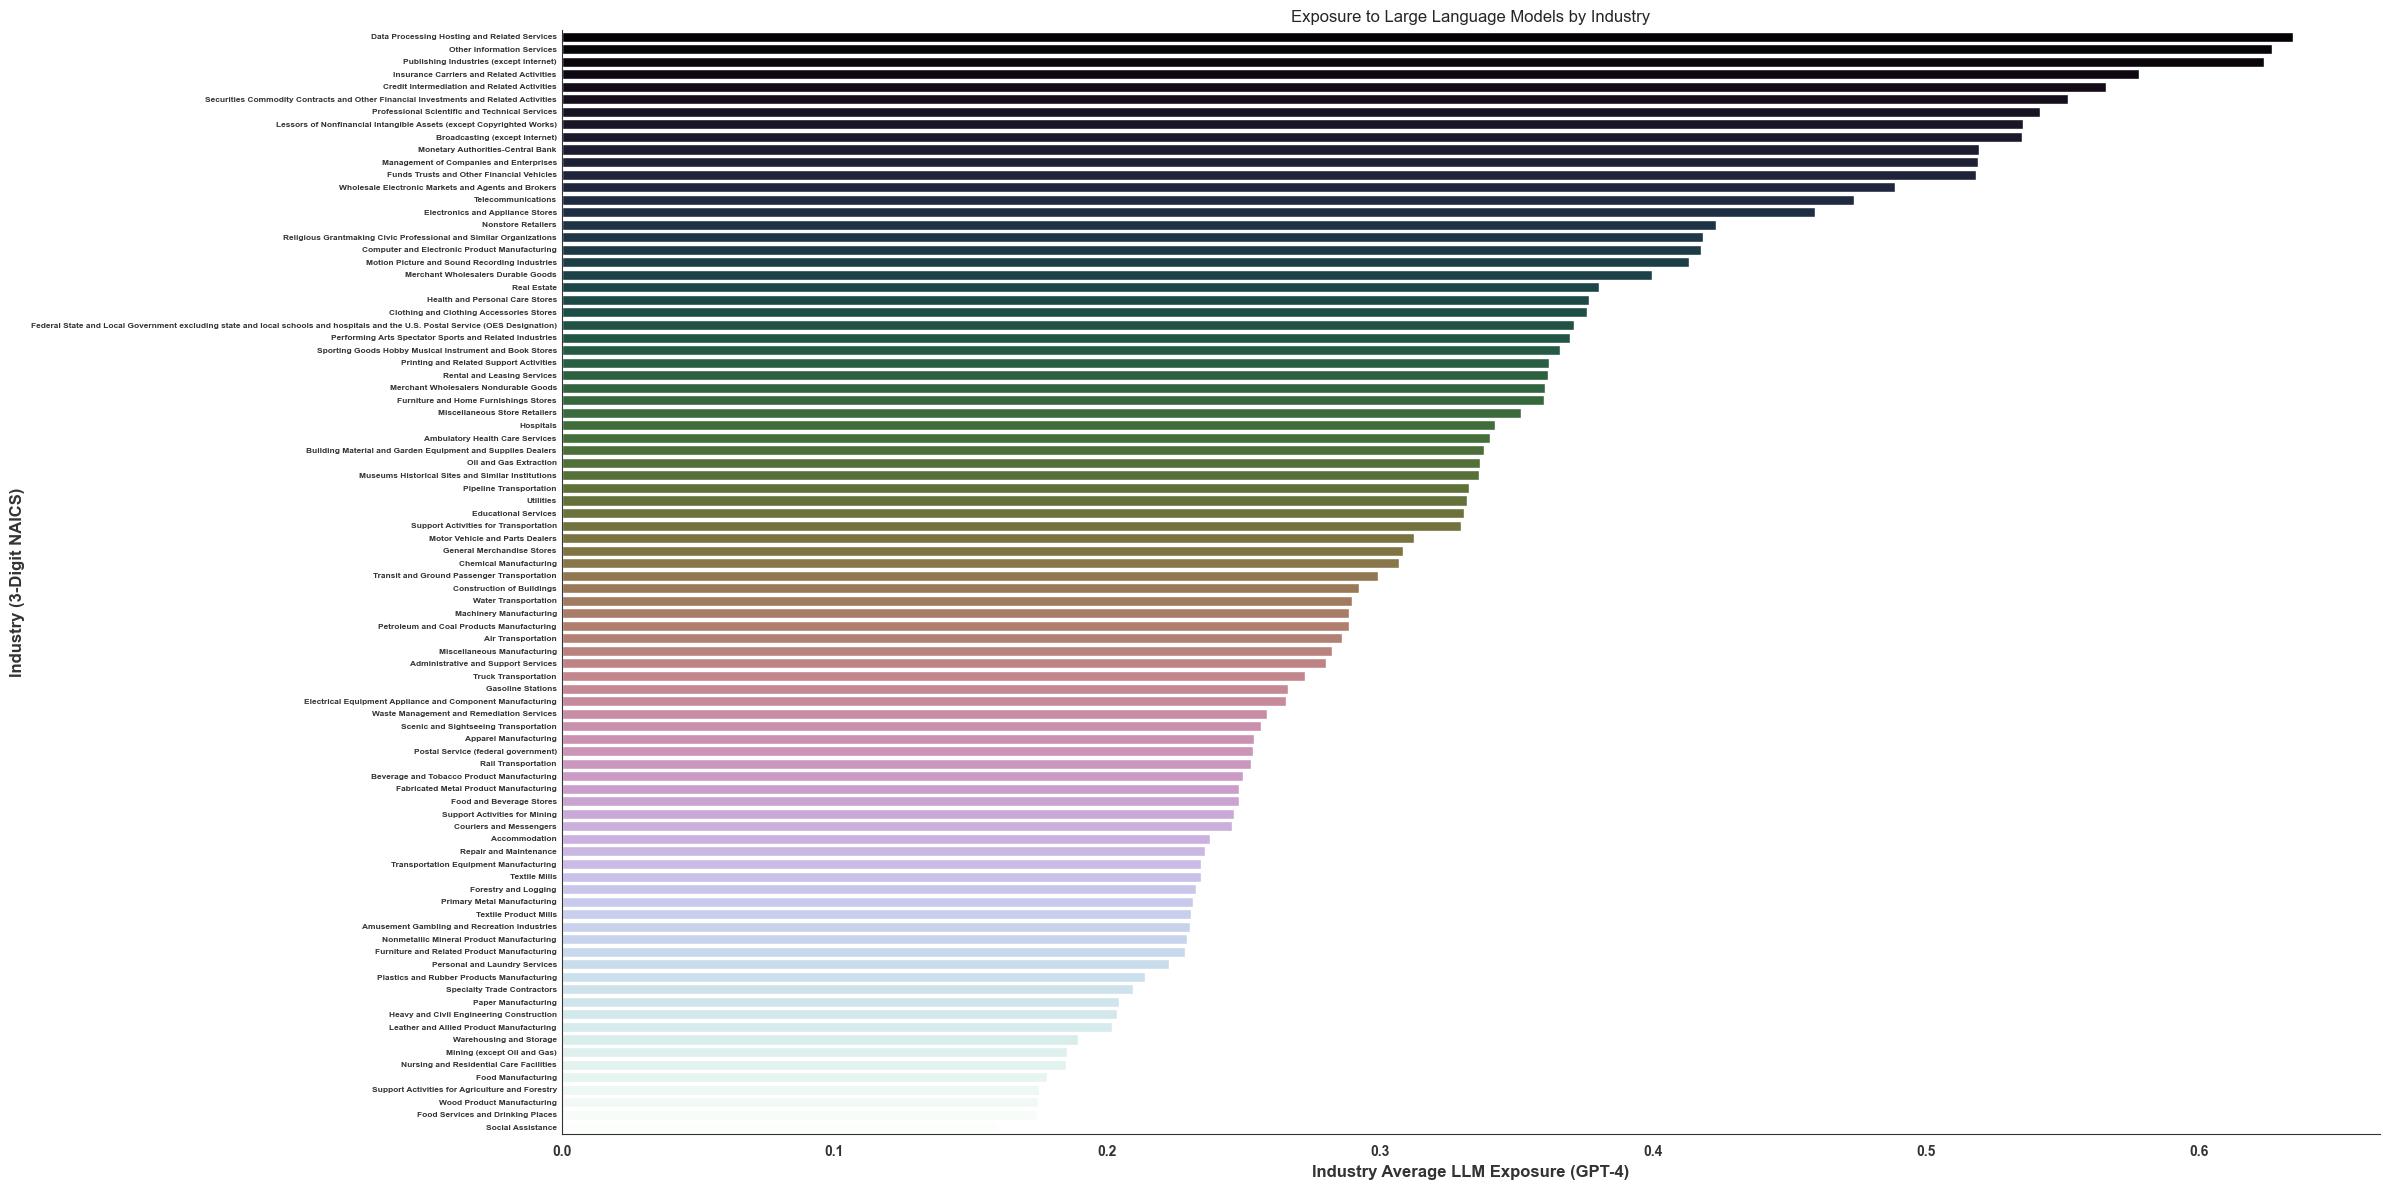

In [209]:
## Industry exposure plot for GPT-4 ratings
oai_ind2 = score_by_ind(ind_df_3_scores, "gpt4_beta")
sorted_oai_ind2 = oai_ind2.sort_values(by="gpt4_beta", ascending=False)

fig, ax = plt.subplots(figsize=(24, 12))
sns.barplot(
    data=sorted_oai_ind2, y="NAICS_TITLE", x="gpt4_beta", palette="cubehelix", ax=ax
)
ax.grid(axis="x")
ax.tick_params(axis="y", labelsize=6)
ax.set_xlabel("Industry Average LLM Exposure (GPT-4)")
ax.set_ylabel("Industry (3-Digit NAICS)")
ax.set_title("Exposure to Large Language Models by Industry")
sns.despine()
plt.tight_layout()
plt.show()

##### Productivity by Industry

In [210]:
# build the labor prod level table. 2012 = 100 for these levels.
lp_raw = pd.read_csv("../data/BEA_BLS_industry_lp.csv")
lp_m = pd.melt(
    lp_raw, id_vars=list(lp_raw)[0:2], var_name="Year", value_name="prod_level"
)
lp_m["prod_type"] = "lp"
lp_m.rename(columns={list(lp_m)[0]: "Industry"}, inplace=True)

# same process for tfp
tfp_raw = pd.read_csv("../data/BEA_BLS_industry_tfp.csv")
tfp_m = pd.melt(
    tfp_raw, id_vars=list(tfp_raw)[0:2], var_name="Year", value_name="prod_level"
)
tfp_m["prod_type"] = "tfp"
tfp_m.rename(columns={list(tfp_m)[0]: "Industry"}, inplace=True)

# stack the two, convert years to int
prod_stats = pd.concat([tfp_m, lp_m], axis=0, ignore_index=True)
prod_stats["Year"] = prod_stats["Year"].astype(int)

# group and calculate the percantage change from the previous year
prod_stats.sort_values(by="Year", ascending=True, inplace=True)
prod_stats["prod_growth"] = prod_stats.groupby(
    ["Industry", "Production Account", "prod_type"]
)["prod_level"].pct_change()

In [212]:
# set up the crosswalk from OES to BEA
## import
'''
bls_bea_crosswalk = pd.read_excel(
    "../data/oesm21in4/bls_bea_industry_crosswalk.xlsx"

)
'''
#print(bls_bea_crosswalk.columns)



bls_bea_crosswalk = pd.read_csv("/Users/gabesmithline/Desktop/GPTs-are-GPTs/data/BEA_BLS_industry_tfp.csv") #replace with the correct path

print(bls_bea_crosswalk.columns)

'''
## some industries are 2 digit, some 3, some 4. Simple function:
def find_BEA_NAICS(row):
    """returns the 6 digit version of the converted naics detail"""
    bea_idx = str(row["NAICSBEA"])
    lenfloat = len(bea_idx)
    return str(row[f"NAICS{lenfloat}OES"])


# now define the relevant BEA-OES lookup key (ignore for now)
bls_bea_crosswalk["OES_ind_key"] = bls_bea_crosswalk.apply(
    lambda x: find_BEA_NAICS(x), axis=1
)
bls_bea_crosswalk["OES_ind_key"] = bls_bea_crosswalk["OES_ind_key"].astype(str)

# replacing the n digit NAICS code so we can merge it to the correct BEA Key. Digits handling here is ugly.
## 2 digits
set2dig = ["22", "23", "42", "44", "45", "55", "61", "81"]
dv3_ind_2["NAICS"].replace("44-45", "44", inplace=True)
dv3_ind_2["NAICS"].replace("48-49", "48", inplace=True)
dv3_ind_2["NAICS"].replace("31-33", "31", inplace=True)
bb_xw_2 = bls_bea_crosswalk[["NAICS2", "Production Account"]].copy().astype(str)
allind2 = pd.merge(bb_xw_2, dv3_ind_2, how="left", left_on="NAICS2", right_on="NAICS")
allind2 = allind2[
    (pd.isnull(allind2["IND_EMP"]) == False) & (allind2["NAICS"].isin(set2dig) == True)
]
allind2.drop("NAICS2", axis=1, inplace=True)

## 3 digits
not_set3dig = [336000, 541000]  # values that are covered by 4 digit
bb_xw_3 = bls_bea_crosswalk[["NAICS3", "Production Account"]].copy().astype(str)
bb_xw_3["NAICS3"] = bb_xw_3["NAICS3"].astype(str).str.slice(start=0, stop=3) + "000"
bb_xw_3["NAICS3"] = bb_xw_3["NAICS3"].astype(int)
allind3 = pd.merge(bb_xw_3, dv3_ind_3, how="left", left_on="NAICS3", right_on="NAICS")
allind3 = allind3[
    (pd.isnull(allind3["IND_EMP"]) == False)
    & (allind3["NAICS"].isin(not_set3dig) == False)
]
allind3.drop("NAICS3", axis=1, inplace=True)

## 4 digits
set4dig = [
    336100,
    336200,
    336300,
    336400,
    336500,
    336600,
    336900,
    541100,
    541200,
    541300,
    541400,
    541500,
    541600,
    541700,
    541800,
    541900,
]
bb_xw_4 = bls_bea_crosswalk[["NAICS4", "Production Account"]].copy().astype(str)
bb_xw_4["NAICS4"] = bb_xw_4["NAICS4"].astype(str).str.slice(start=0, stop=4) + "00"
bb_xw_4["NAICS4"] = bb_xw_4["NAICS4"].astype(int)
allind4 = pd.merge(bb_xw_4, dv3_ind_4, how="left", left_on="NAICS4", right_on="NAICS")
allind4 = allind4[
    (pd.isnull(allind4["IND_EMP"]) == False) & (allind4["NAICS"].isin(set4dig) == True)
]
allind4.drop("NAICS4", axis=1, inplace=True)

# stack each type of naics
allind = pd.concat(
    [allind2, allind3, allind4], axis=0, ignore_index=True
).drop_duplicates()

# merge to prod_stats
prod_exp = pd.merge(prod_stats, allind, how="left", on="Production Account")
'''
# Load TFP data
bls_bea_crosswalk = pd.read_csv("/Users/gabesmithline/Desktop/GPTs-are-GPTs/data/BEA_BLS_industry_tfp.csv") #replace with the correct path

# Create industry code mapping dictionary
industry_mapping = {
    # Agriculture and related
    '111CA': '11', '113FF': '11',
    
    # Mining
    '211': '21', '212': '21', '213': '21',
    
    # Utilities and Construction
    '22': '22', '23': '23',
    
    # Manufacturing
    '311FT': '31', '313TT': '31', '315AL': '31',
    '321': '32', '322': '32', '323': '32', '324': '32', 
    '325': '32', '326': '32', '327': '32',
    '331': '33', '332': '33', '333': '33', '334': '33', 
    '335': '33', '3361MV': '336', '3364OT': '336', 
    '337': '33', '339': '33',
    
    # Trade
    '42': '42', '44RT': '44',
    
    # Transportation
    '481': '48', '482': '48', '483': '48', '484': '48',
    '485': '48', '486': '48', '487OS': '48', '493': '49',
    
    # Information
    '511': '51', '512': '51', '513': '51', '514': '51',
    
    # Finance and Insurance
    '521CI': '52', '523': '52', '524': '52', '525': '52',
    
    # Real Estate and Rental
    '531': '53', '532RL': '53',
    
    # Professional Services
    '5411': '541', '5412OP': '541', '5415': '541', '55': '55',
    
    # Administrative Services
    '561': '56', '562': '56',
    
    # Education and Healthcare
    '61': '61', '621': '62', '622HO': '62', '624': '62',
    
    # Entertainment and Recreation
    '711AS': '71', '713': '71',
    
    # Accommodation and Food
    '721': '72', '722': '72',
    
    # Other Services
    '81': '81'
}

# Define industry sets for different NAICS levels
set2dig = ["22", "23", "42", "44", "45", "55", "61", "81"]

# Create copies of dataframes to avoid warnings
dv3_ind_2 = dv3_ind_2.copy()
dv3_ind_3 = dv3_ind_3.copy()
dv3_ind_4 = dv3_ind_4.copy()

# Update NAICS codes in dv3_ind_2
dv3_ind_2["NAICS"] = dv3_ind_2["NAICS"].replace({
    "44-45": "44",
    "48-49": "48",
    "31-33": "31"
})

# Create industry level aggregations
allind2 = dv3_ind_2[dv3_ind_2["NAICS"].isin(set2dig)].copy()
allind3 = dv3_ind_3.copy()
allind4 = dv3_ind_4.copy()

# Stack each type of NAICS
allind = pd.concat([allind2, allind3, allind4], axis=0, ignore_index=True).drop_duplicates()

# Clean up industry names for matching
allind['NAICS_TITLE'] = allind['NAICS_TITLE'].str.strip()
prod_stats['Production Account'] = prod_stats['Production Account'].str.strip()

# Create mapped columns for merging
prod_stats['NAICS_mapped'] = prod_stats['Production Account'].map(industry_mapping)
allind['NAICS_base'] = allind['NAICS'].str[:2]  # Take first 2 digits for base comparison

# Merge the datasets using the mapped codes
prod_exp = pd.merge(
    prod_stats,
    allind,
    left_on='NAICS_mapped',
    right_on='NAICS_base',
    how='left'
)

# Print information about the merge
print("\nMerge Results:")
print("Original prod_stats shape:", prod_stats.shape)
print("Original allind shape:", allind.shape)
print("Merged prod_exp shape:", prod_exp.shape)

# Check for unmatched industries
unmatched = prod_stats[pd.isna(prod_stats['NAICS_mapped'])]
if len(unmatched) > 0:
    print("\nUnmatched industries:")
    print(unmatched['Production Account'].unique())

# Check merge quality
matched = prod_stats[~pd.isna(prod_exp['NAICS'])]
print("\nNumber of successfully matched industries:", len(matched))
print("Matching rate: {:.1f}%".format(len(matched) / len(prod_stats) * 100))

Index(['Integrated Total Factor Productivity* (2012=100)',
       'Production Account', '1987', '1988', '1989', '1990', '1991', '1992',
       '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001',
       '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
       '2020'],
      dtype='object')

Merge Results:
Original prod_stats shape: (4284, 7)
Original allind shape: (345, 5)
Merged prod_exp shape: (69156, 12)

Unmatched industries:
['GF' 'GSL']

Number of successfully matched industries: 4264
Matching rate: 99.5%


/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_12941/3849293256.py:202: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [213]:
# moving average productivity growth
prod_exp["prod_growth_5year"] = (
    prod_exp[["Production Account", "prod_type", "prod_growth"]]
    .groupby(["Production Account", "prod_type"])
    .rolling(5)["prod_growth"]
    .mean()
    .reset_index(drop=True)
    * 100.0
)

prod_exposure_latest = prod_exp[prod_exp["Year"] == 2020].copy()
prod_exposure_latest.dropna(axis=0, inplace=True)

<Figure size 1000x600 with 0 Axes>

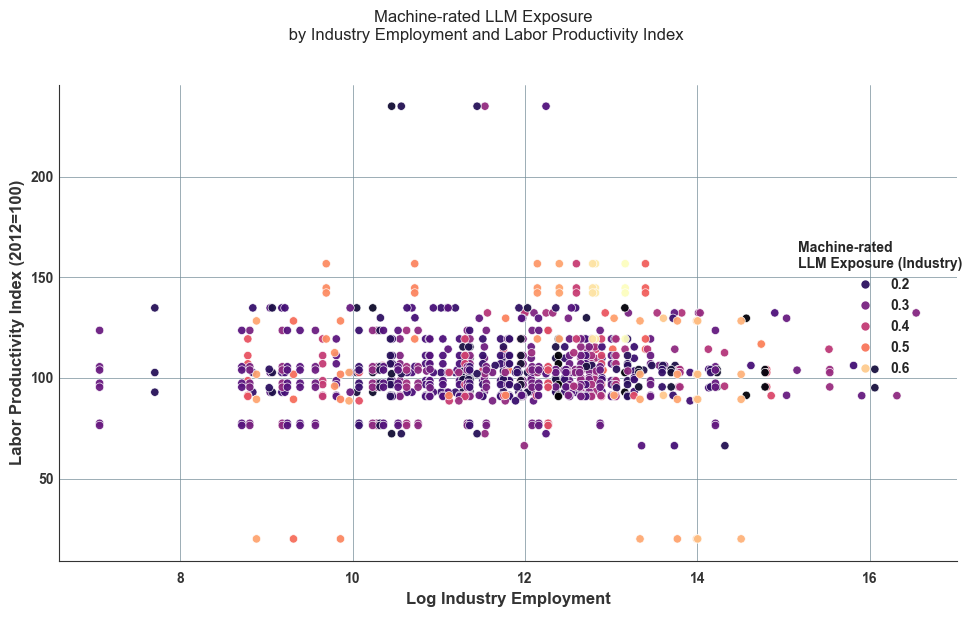

In [214]:
'''
### labor productivity graph for GPT-4 Rubric 1
prod_exposure_latest["log_ind_emp"] = np.log(prod_exposure_latest["IND_EMP"])
prodplot = sns.relplot(
    x="log_ind_emp",
    y="prod_level",
    hue="gpt4_beta",
    palette="magma",
    alpha=0.95,
    data=prod_exposure_latest[prod_exposure_latest["prod_type"] == "lp"],
)
prodplot.set_axis_labels(
    "Log Industry Employment", "Labor Productivity Index (2012=100)"
)
prodplot._legend.set_title("Machine-rated \nLLM Exposure (Industry)")
prodplot.set(
    title="Machine-rated LLM Exposure\n by Industry Employment and Labor Productivity Index"
)

print(prodplot)
'''
# Labor productivity graph for GPT-4 Rubric 1
prod_exposure_latest["log_ind_emp"] = np.log(prod_exposure_latest["IND_EMP"])

# Create the plot with explicit legend settings
plt.figure(figsize=(10, 6))
prodplot = sns.relplot(
    data=prod_exposure_latest[prod_exposure_latest["prod_type"] == "lp"],
    x="log_ind_emp",
    y="prod_level",
    hue="gpt4_beta",
    palette="magma",
    alpha=0.95,
    height=6,
    aspect=1.5,
    legend="brief"
)

# Set labels and title
prodplot.fig.suptitle(
    "Machine-rated LLM Exposure\n by Industry Employment and Labor Productivity Index",
    y=1.02
)
prodplot.ax.set_xlabel("Log Industry Employment")
prodplot.ax.set_ylabel("Labor Productivity Index (2012=100)")

# Modify legend
if prodplot._legend is not None:
    prodplot._legend.set_title("Machine-rated\nLLM Exposure (Industry)")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

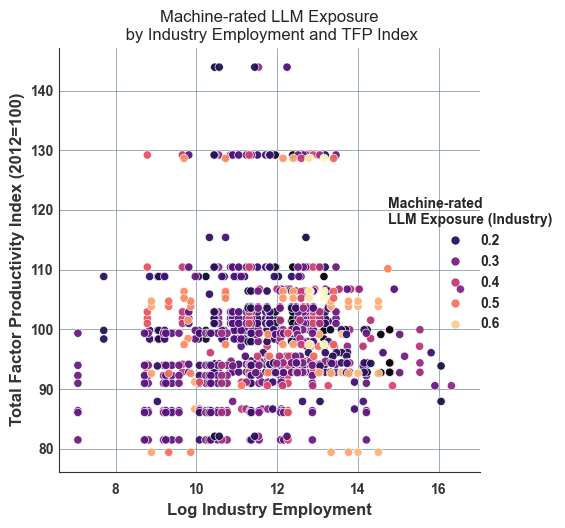

In [215]:
### total factor productivity graph for GPT-4 Rubric 1
prod_exposure_latest["log_ind_emp"] = np.log(prod_exposure_latest["IND_EMP"])
prodplot = sns.relplot(
    x="log_ind_emp",
    y="prod_level",
    hue="gpt4_beta",
    palette="magma",
    alpha=0.95,
    data=prod_exposure_latest[prod_exposure_latest["prod_type"] == "tfp"],
)
prodplot.set_axis_labels(
    "Log Industry Employment", "Total Factor Productivity Index (2012=100)"
)
prodplot._legend.set_title("Machine-rated \nLLM Exposure (Industry)")
prodplot.set(title="Machine-rated LLM Exposure\n by Industry Employment and TFP Index")

##### Automation Scores

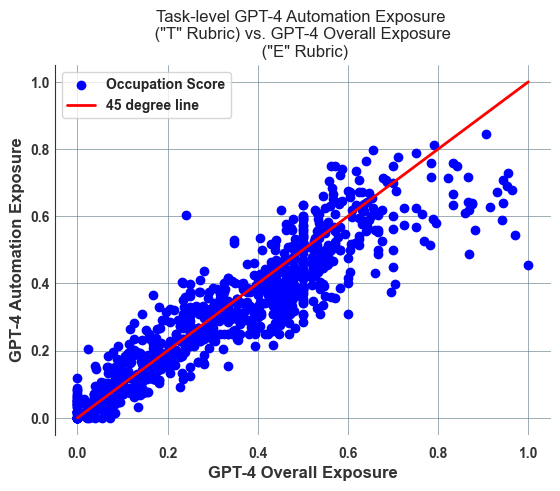

In [216]:
## Exposure Rubric (GPT-4 #1) vs. Automation Rubric
plt.scatter(occ_lvl["gpt4_beta"], occ_lvl["automation"], color="blue")
plt.title(
    'Task-level GPT-4 Automation Exposure \n ("T" Rubric) vs. GPT-4 Overall Exposure \n ("E" Rubric)'
)
plt.plot([0, 1], [0, 1], color="red", linewidth=2)
plt.xlabel("GPT-4 Overall Exposure")
plt.ylabel("GPT-4 Automation Exposure")
plt.legend(["Occupation Score", "45 degree line"])

In [217]:
# Tabulate the GPT-4 label counts
full_labels["gpt4_automation"].value_counts()

gpt4_automation
T1    6284
T0    5746
T3    3879
T2    3224
T4     132
Name: count, dtype: int64

In [218]:
df_auto = read_tsv("../data/automation_gpt4_human_labels.tsv")
df_auto = df_auto[df_auto["human_automation"].isin(["T0", "T1", "T2", "T3", "T4"])]

# make sure both the human and model labels are strings
df_auto["gpt4_automation"] = df_auto["gpt4_automation"].astype(str)
df_auto["human_automation"] = df_auto["human_automation"].astype(str)

In [219]:
# compute the Cohen's Kappa score for the model outputs and the golden labels for taxonomy 4
kappa_ = cohen_kappa_score(df_auto["gpt4_automation"], df_auto["human_automation"])
print(kappa_)

0.5380757555760856


In [220]:
# run a crosstab comparing dv_automation_rating and human_label_sm
pd.crosstab(df_auto["gpt4_automation"], df_auto["human_automation"])

human_automation,T0,T1,T2,T3,T4
gpt4_automation,,,,,
T0,19,1,0,0,0
T1,2,12,2,0,0
T2,3,15,21,4,0
T3,1,0,3,13,4


##### Other scores comparison

In [221]:
## Other scores (e.g. Felten, Raj, Seamans / Brynjolfsson, Mitchell, Rock / Frey & Osborne / Webb, etc.)
outside = pd.read_csv("../data/autoScores.csv")
outside.drop(columns="Unnamed: 0", inplace=True)

autoo = outside[outside.year == 2019][
    [
        "simpleOcc",
        "lswt2010",
        "pct_software",
        "pct_robot",
        "pct_ai",
        "mSML",
        "measure",
        "smlObs",
        "normComputer",
        "normalized_r_cog",
        "normalized_r_man",
        "felten_raj_seamans",
        "freyOsborne",
    ]
].copy()
scorepile = pd.merge(autoo, occ_lvl, on="simpleOcc")

In [222]:
## standardize scores
from scipy import stats

cols_to_standardize = [
    "pct_software",
    "pct_robot",
    "pct_ai",
    "mSML",
    "measure",
    "smlObs",
    "normComputer",
    "normalized_r_cog",
    "normalized_r_man",
    "felten_raj_seamans",
    "freyOsborne",
]
norm_scorepile = scorepile.copy()
norm_scorepile[cols_to_standardize] = stats.zscore(
    norm_scorepile[cols_to_standardize], nan_policy="omit"
)

In [223]:
## test regression (main results in .do file for stata)
modelai = smf.ols(
    formula="human_beta ~ pct_ai + mSML + felten_raj_seamans + normalized_r_cog + normalized_r_man",
    data=scorepile,
)
ols_ai = modelai.fit(cov_type="HC3")
ols_ai.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             human_beta   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     289.8
Date:                Sun, 01 Dec 2024   Prob (F-statistic):          6.44e-172
Time:                        15:20:09   Log-Likelihood:                 451.60
No. Observations:                 750   AIC:                            -891.2
Df Residuals:                     744   BIC:                            -863.5
Df Model:                           5                                         
Covariance Type:                  HC3                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.3365      0.143     -2.350      0.019      -0.617      -0.056
pct_ai                 0.0004      0.000      1.987      0.047    5.38e-06       0.001
mSML                   0.1678      0.041      4.060      0.000       0.087       0.249
felten_raj_seamans     0.0319      0.009      3.401      0.001       0.014       0.050
normalized_r_cog       0.0458      0.008      6.094      0.000       0.031       0.061
normalized_r_man      -0.1827      0.006    -33.140      0.000      -0.194      -0.172
==============================================================================
Omnibus:                        1.156   Durbin-Watson:                   1.197
Prob(Omnibus):                  0.561   Jarque-Bera (JB):                1.017
Skew:                           0.080   Prob(JB):                        0.601
Kurtosis:                       3.084   Cond. No.                     1.79e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 1.79e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Results and Analysis

In [224]:
## Crosswalks and BLS data
official_crosswalk = pd.read_excel(
    "../data/nem-onet-to-soc-crosswalk.xlsx",
    sheet_name="ONET to SOC crosswalk",
    skiprows=range(4),
)
# Keep the following columns ['O*NET-SOC 2021 Title', 'National Employment Matrix Occupational Title']
# official_crosswalk = official_crosswalk[['O*NET-SOC 2021 Title', 'National Employment Matrix Occupational Title']]
official_crosswalk = official_crosswalk[
    ["O*NET-SOC Title", "National Employment Matrix Occupational Title"]
]
official_crosswalk.columns = ["onet_bls_name_official", "nem_occupation"]

bls_work_chars_2023 = pd.read_excel(
    "../data/occupation_2023_final.xlsx", sheet_name="Table 1.7", skiprows=range(1)
)

In [225]:
# 2021 National Employment Matrix title	2021 National Employment Matrix
# code	Occupation type	Employment, 2021	Employment, 2031	Employment change, 2021-31	Percent employment change, 2021-31	Percent self employed, 2021	Occupational openings, 2021-31 annual average	Median annual wage, 2021(1)	Typical education needed for entry	Work experience in a related occupation	Typical on-the-job training needed to attain competency in the occupation
# Source: https://www.bls.gov/emp/tables/emp-by-detailed-occupation.htm

# rename columns
bls_work_chars_2023.columns = [
    "nem_occupation",
    "onet_bls_code",
    "occupation_type",
    "TOT_EMP_2022",
    "TOT_EMP_2032",
    "projected_employment_change_2022_2032",
    "pct_employment_change_2022_2032",
    "percent_self_employed_2022",
    "occupational_openings_2022_2032",
    "A_MEDIAN_2022",
    "typical_education_needed_for_entry",
    "work_experience_in_related_occupation",
    "on_the_job_training_needed_to_attain_competency",
]
# drop rows with missing onet_bls_code
bls_work_chars_2023 = bls_work_chars_2023.dropna(subset=["onet_bls_code"])
bls_work_chars_2023["nem_occupation"] = bls_work_chars_2023[
    "nem_occupation"
].str.strip()  # remove leading spaces

# merge bls_work_chars_2023 with official_crosswalk
bls_work_chars_2023_merged = bls_work_chars_2023.merge(
    official_crosswalk, on="nem_occupation", how="inner"
)

# drop onet_bls_code, occupation_type
bls_work_chars_2023_merged = bls_work_chars_2023_merged.drop(
    columns=["onet_bls_code", "occupation_type"]
)
bls_work_chars_2023_merged

,nem_occupation,TOT_EMP_2022,TOT_EMP_2032,projected_employment_change_2022_2032,pct_employment_change_2022_2032,percent_self_employed_2022,occupational_openings_2022_2032,A_MEDIAN_2022,typical_education_needed_for_entry,work_experience_in_related_occupation,on_the_job_training_needed_to_attain_competency,onet_bls_name_official
0,Chief executives,280.0,257.0,-23.0,-8.2,21.2,15.3,189520,Bachelor's degree,5 years or more,NaN,Chief Executives
1,Chief executives,280.0,257.0,-23.0,-8.2,21.2,15.3,189520,Bachelor's degree,5 years or more,NaN,Chief Sustainability Officers
2,General and operations managers,3507.8,3655.1,147.3,4.2,0.3,296.3,98100,Bachelor's degree,5 years or more,NaN,General and Operations Managers
3,Legislators,44.4,46.0,1.5,3.4,—,3.4,48090,Bachelor's degree,Less than 5 years,NaN,Legislators
4,Advertising and promotions managers,30.9,31.4,0.6,1.9,27,2.8,127830,Bachelor's degree,Less than 5 years,NaN,Advertising and Promotions Managers
...,...,...,...,...,...,...,...,...,...,...,...,...
996,"Pump operators, except wellhead pumpers",11.2,11.6,0.4,3.6,—,1.2,55860,High school diploma or equivalent,NaN,Moderate-term on-the-job training,"Pump Operators, Except Wellhead Pumpers"
997,Wellhead pumpers,16.2,15.9,-0.4,-2.2,0.4,1.6,63280,High school diploma or equivalent,Less than 5 years,Moderate-term on-the-job training,Wellhead Pumpers
998,Refuse and recyclable material collectors,146.4,151.1,4.7,3.2,7.6,18.6,43540,No formal educational credential,NaN,Short-term on-the-job training,Refuse and Recyclable Material Collectors
999,"Tank car, truck, and ship loaders",13.3,13.5,0.2,1.6,3.3,1.6,53930,No formal educational credential,NaN,Short-term on-the-job training,"Tank Car, Truck, and Ship Loaders"


##### demographics

In [226]:
demo_df_new = pd.read_excel(
    "../data/cpsaat11.xlsx", sheet_name="cpsaat11", skiprows=range(5)
)
# drop if Unanamed: 0 is NaN
demo_df_new = demo_df_new.dropna(subset=["Unnamed: 0"])
# rename the columns to be more readable to change Unnamed: 0 to bls_occupation and Unnamed: 1 to bls_tot_emp, and change the remaining columns to be lower case
demo_df_new.rename(
    columns={"Unnamed: 0": "bls_occupation", "Unnamed: 1": "bls_tot_emp"}, inplace=True
)
demo_df_new.columns = demo_df_new.columns.str.lower()
demo_df_new.rename(
    columns={"black or\nafrican\namerican": "black", "hispanic\nor latino": "hispanic"},
    inplace=True,
)

# merge with bls_work_chars_2023_merged on bls_occupation and nem_occupation
# bls_work_chars_2023_merged = bls_work_chars_2023_merged.merge(demo_df_new, left_on='nem_occupation', right_on='bls_occupation', how='left')
bls_work_chars_2023_merged = bls_work_chars_2023_merged.merge(
    demo_df_new, left_on="nem_occupation", right_on="bls_occupation", how="left"
)
print(bls_work_chars_2023_merged.shape)

(1001, 19)


In [227]:
full_labels["occupation"] = full_labels["Title"].copy()

########################################################################################
income_df = pd.read_csv("../data/occupations_onet_bls_matched.csv")
income_df = income_df[["occupation", "onet_bls_name", "A_MEDIAN", "TOT_EMP"]]
income_df = income_df.dropna(subset=["occupation"])

################################################################################################
skills_df = pd.read_csv("../data/occupations_onet_basic_skills.csv")
skills_df.columns = skills_df.columns.str.lower()

################################################################################################
work_projections_df = pd.read_csv("../data/occupations_projections_processed.csv")

################################################################################################
demo_df = pd.read_excel(
    "../data/bls_occupation_demographics_2022.xlsx",
    sheet_name="cpsaat11",
    skiprows=[0, 1, 2, 3, 4, 6, 7, 8, 607, 608],
)
demo_df.columns = [
    "occupation_name_bls",
    "total_employed",
    "women",
    "white",
    "black_africanamerican",
    "asian",
    "hispanic_latino",
]

################################################################################################
# get work context data
work_contexts_df = pd.read_csv("../data/occupations_onet_work_contexts.csv")

In [228]:
########################################################################################
# MERGE DATA from VARIOUS SOURCES
########################################################################################
income_demo_df_new = copy.deepcopy(bls_work_chars_2023_merged)
# print(income_demo_df_new.columns)
captured_workers = income_demo_df_new["TOT_EMP_2022"].sum()
# duplicates drop
content_skills_list = [
    "active listening",
    "mathematics",
    "reading comprehension",
    "science",
    "speaking",
    "writing",
]
process_skills_list = [
    "active learning",
    "critical thinking",
    "learning strategies",
    "monitoring",
]
cross_functional_skills_list = ["programming"]

basic_skills = content_skills_list + process_skills_list + cross_functional_skills_list
basic_skills = [skill.lower() for skill in basic_skills]

skills_list = basic_skills
for sk in skills_list:
    sk = sk.replace(" ", "_")
    # for all the skills in basic skills, replace "Not Relevant" and "Not Available" with NaN, then convert to float
    skills_df[f"{sk}_level"] = (
        skills_df[f"{sk}_level"]
        .replace(["Not relevant", "Not available"], "NaN")
        .astype(float)
    )

print(income_demo_df_new.columns)
print(skills_df.columns)
# merge income_demo_df left with skills_df on occupation and occupation
income_demo_skills_df = pd.merge(
    income_demo_df_new,
    skills_df,
    left_on="onet_bls_name_official",
    right_on="occupation",
    how="left",
)
print(income_demo_skills_df.shape)

# merge in work contexts
income_demo_skills_projections_work_contexts_df = pd.merge(
    income_demo_skills_df,
    work_contexts_df,
    left_on="occupation",
    right_on="occupation",
    how="left",
)
income_demo_skills_projections_work_contexts_df.columns

final_data = copy.deepcopy(income_demo_skills_projections_work_contexts_df)

# inspect the non-matches

Index(['nem_occupation', 'TOT_EMP_2022', 'TOT_EMP_2032',
       'projected_employment_change_2022_2032',
       'pct_employment_change_2022_2032', 'percent_self_employed_2022',
       'occupational_openings_2022_2032', 'A_MEDIAN_2022',
       'typical_education_needed_for_entry',
       'work_experience_in_related_occupation',
       'on_the_job_training_needed_to_attain_competency',
       'onet_bls_name_official', 'bls_occupation', 'bls_tot_emp', 'women',
       'white', 'black', 'asian', 'hispanic'],
      dtype='object')
Index(['occupation', 'job zone', 'active_learning_importance',
       'active_learning_level', 'critical_thinking_importance',
       'critical_thinking_level', 'learning_strategies_importance',
       'learning_strategies_level', 'monitoring_importance',
       'monitoring_level', 'active_listening_importance',
       'active_listening_level', 'mathematics_importance', 'mathematics_level',
       'programming_importance', 'programming_level',
       'reading_compr

In [229]:
from plot_styles import *

In [230]:
# merge with master labels
final_data = final_data.drop_duplicates(subset=["occupation"])
final_data_w_labels = pd.merge(
    full_labels, final_data, left_on="occupation", right_on="occupation", how="left"
)

# take the log of A_MEDIAN
# replace * and # in A_MEDIAN with NaN and then convert to float
# remove all string characters from A_MEDIAN_2021 with NaN and then convert to float, do it with regex
final_data_w_labels["A_MEDIAN"] = (
    final_data_w_labels["A_MEDIAN_2022"]
    .replace("[^0-9.]", np.nan, regex=True)
    .astype(float)
)
final_data_w_labels["A_MEDIAN_LOG"] = np.log(final_data_w_labels["A_MEDIAN"])
final_data_w_labels["TOT_EMP"] = final_data_w_labels["TOT_EMP_2022"]
final_data_w_labels.columns

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_12941/903699135.py:12: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Index(['Unnamed: 0', 'O*NET-SOC Code', 'Task ID', 'Task', 'Task Type', 'Title',
       'human_exposure', 'gpt4_exposure', 'gpt4_alt_exposure',
       'gpt_3_relevant', 'gpt4_automation', 'alpha', 'beta', 'gamma',
       'automation', 'human_labels', 'gpt4_alpha', 'gpt4_beta', 'gpt4_gamma',
       'human_alpha', 'human_beta', 'human_gamma', 'gpt4_alt_beta',
       'occupation', 'nem_occupation', 'TOT_EMP_2022', 'TOT_EMP_2032',
       'projected_employment_change_2022_2032',
       'pct_employment_change_2022_2032', 'percent_self_employed_2022',
       'occupational_openings_2022_2032', 'A_MEDIAN_2022',
       'typical_education_needed_for_entry',
       'work_experience_in_related_occupation',
       'on_the_job_training_needed_to_attain_competency',
       'onet_bls_name_official', 'bls_occupation', 'bls_tot_emp', 'women',
       'white', 'black', 'asian', 'hispanic', 'job zone',
       'active_learning_importance', 'active_learning_level',
       'critical_thinking_importance', 'criti

In [231]:
def get_percentages(df, column, extra_groupby_columns=None):
    if extra_groupby_columns is None:
        tasks = df.groupby(["occupation", column]).size().reset_index(name="counts")
        tasks["percent"] = tasks.groupby(["occupation"])["counts"].transform(
            lambda x: 100 * x / float(x.sum())
        )
        tasks = tasks.pivot(
            index=["occupation"], columns=column, values="percent"
        ).reset_index()
    else:
        tasks = (
            df.groupby(["occupation", *extra_groupby_columns, column])
            .size()
            .reset_index(name="counts")
        )
        tasks["percent"] = tasks.groupby(["occupation", *extra_groupby_columns])[
            "counts"
        ].transform(lambda x: 100 * x / float(x.sum()))
        tasks = tasks.pivot(
            index=["occupation", *extra_groupby_columns],
            columns=column,
            values="percent",
        ).reset_index()

    tasks = tasks.rename(
        columns={"E0": "E0_percent", "E1": "E1_percent", "E2": "E2_percent"}
    )
    tasks[tasks.filter(like="percent").columns] = tasks.filter(like="percent").fillna(0)

    tasks["gpt_relevance_a"] = tasks["E1_percent"]
    tasks["gpt_relevance_b"] = tasks["E1_percent"] + 0.5 * tasks["E2_percent"]
    tasks["gpt_relevance_c"] = tasks["E1_percent"] + tasks["E2_percent"]
    return tasks


def get_exposure_points(df, type="occupation", relevance_type="a"):
    thresholds = np.arange(0, 100, 5)
    outcome = {}
    for threshold in thresholds:
        outcome[threshold] = (
            df[df[f"gpt_relevance_{relevance_type}"] > threshold].shape[0]
            if type == "occupation"
            else df[df[f"gpt_relevance_{relevance_type}"] > threshold]["TOT_EMP"].sum()
        )
    outcome = pd.DataFrame.from_dict(outcome, orient="index", columns=["count"])
    outcome["threshold"] = outcome.index
    outcome["percent"] = (
        outcome["count"] / len(df) * 100
        if type == "occupation"
        else outcome["count"] / sum(df["TOT_EMP"]) * 100
    )
    return outcome


def get_exposure_median_income(df, type="a"):
    thresholds = np.arange(0, 100, 5)
    outcome = {}
    for threshold in thresholds:
        filtered_df = df[df[f"gpt_relevance_{type}"] > threshold]
        outcome[threshold] = filtered_df["A_MEDIAN_LOG"].median()
    outcome = pd.DataFrame.from_dict(outcome, orient="index", columns=["median_income"])
    outcome["threshold"] = outcome.index
    return outcome


def get_skill_correlations(list_of_dfs, list_of_stubs, skills_df, skills_list):
    big_df = None
    for df, stub in zip(list_of_dfs, list_of_stubs):

        skills_results = []
        df_skills = df.merge(
            skills_df, left_on="occupation", right_on="occupation", how="left"
        )
        for sk in skills_list:
            sk = sk.replace(" ", "_")
            # for all the skills in basic skills, replace "Not Relevant" and "Not Available" with NaN, then convert to float
            df_skills[f"{sk}_level"] = (
                df_skills[f"{sk}_level"]
                .replace(["Not relevant", "Not available"], "NaN")
                .astype(float)
            )
            income_corr = (
                df_skills["A_MEDIAN_LOG"].corr(df_skills[f"{sk}_importance"]).round(3)
            )  # economically valuable
            exposure_corr = (
                df_skills[f"E1_percent"].corr(df_skills[f"{sk}_importance"]).round(3)
            )
            # f"income_corr_{stub}": income_corr,
            skills_results.append({"skill": sk, f"exposure_corr_{stub}": exposure_corr})
        skills_df_new = pd.DataFrame(skills_results)

        # df_skills['stub'] = stub
        print("skills_df_new: ", skills_df_new)
        if big_df is None:
            big_df = skills_df_new
        else:
            big_df = pd.merge(big_df, skills_df_new, on="skill", how="outer")
    return big_df


def plot_joli_scatterplot(df, x, y, size, title, xlabel, ylabel, color):
    params = PLOT_PARAMS
    sns.set_style("whitegrid")
    sns.set_palette("bright")
    plt.rcParams.update(params)
    # ax = sns.scatterplot(data=df, x=x, y=y, hue=hue, cmap=color, marker='o', size=100)
    ax = sns.scatterplot(data=df, x=x, y=y, size=size, cmap=color, marker="o")
    ax.set_xlabel(xlabel, fontsize=14, fontstyle="italic", color="#191919")
    ax.set_ylabel(ylabel, fontsize=14, fontstyle="italic", color="#191919")
    ax.set_title(title, fontsize=18, fontweight="bold", color="#191919")
    plt.show()

    tasks["gpt_relevance_a"] = tasks["E1_percent"]
    tasks["gpt_relevance_b"] = tasks["E1_percent"] + 0.5 * tasks["E2_percent"]
    tasks["gpt_relevance_c"] = tasks["E1_percent"] + tasks["E2_percent"]
    return tasks

In [232]:
check_date_a = get_exposure_points(
    get_percentages(final_data_w_labels, "human_exposure", ["TOT_EMP"]),
    type="workers",
    relevance_type="a",
)
check_date_b = get_exposure_points(
    get_percentages(final_data_w_labels, "human_exposure", ["TOT_EMP"]),
    type="workers",
    relevance_type="b",
)
check_date_c = get_exposure_points(
    get_percentages(final_data_w_labels, "human_exposure", ["TOT_EMP"]),
    type="workers",
    relevance_type="c",
)

In [233]:
check_date_a

,count,threshold,percent
0,168922.1,0,80.107564
5,150506.7,5,71.374469
10,129578.3,10,61.449639
15,97642.9,15,46.304983
20,59469.2,20,28.201951
25,44182.2,25,20.952430
30,27483.4,30,13.033394
35,20241.7,35,9.599178
40,14556.0,40,6.902861
45,5653.9,45,2.681237


In [234]:
# abstract number 2
(
    check_date_c[check_date_c["threshold"] == 10]["percent"].values[0]
    - check_date_a[check_date_a["threshold"] == 10]["percent"].values[0]
)

# abstract number 3
(
    check_date_c[check_date_c["threshold"] == 50]["percent"].values[0]
    - check_date_a[check_date_a["threshold"] == 50]["percent"].values[0]
)

np.float64(46.61721418643129)

In [235]:
# summarize the exposure statistics
def summarize_exposure(df):
    exposure_stats = {}
    for i in ["a", "b", "c"]:
        mean = df[f"gpt_relevance_{i}"].mean()
        std = df[f"gpt_relevance_{i}"].std()
        exposure_stats[f"mean_gpt_relevance_{i}"] = mean
        exposure_stats[f"std_gpt_relevance_{i}"] = std

    # Another option is to reshape the dictionary into a format that can be directly converted into a dataframe:
    new_dict = {
        "a": {
            "mean": exposure_stats["mean_gpt_relevance_a"],
            "std": exposure_stats["std_gpt_relevance_a"],
        },
        "b": {
            "mean": exposure_stats["mean_gpt_relevance_b"],
            "std": exposure_stats["std_gpt_relevance_b"],
        },
        "c": {
            "mean": exposure_stats["mean_gpt_relevance_c"],
            "std": exposure_stats["std_gpt_relevance_c"],
        },
    }

    df = pd.DataFrame.from_dict(data=new_dict, orient="index")
    return df

In [236]:
summarize_exposure(get_percentages(final_data_w_labels, "human_exposure"))

,mean,std
a,14.405115,14.236396
b,30.158327,20.602590
c,45.911540,29.507515


In [237]:
summarize_exposure(get_percentages(final_data_w_labels, "gpt4_exposure"))

,mean,std
a,14.032963,16.301587
b,34.319902,21.933161
c,54.606841,34.370690


In [238]:
# make a dummy variable for E1
final_data_w_labels["E1_dummy"] = np.where(
    final_data_w_labels["human_exposure"] == "E1", 1, 0
)
final_data_w_labels["E2_dummy"] = np.where(
    final_data_w_labels["human_exposure"] == "E2", 1, 0
)

# calculate the mean and std of the E1_dummy variable
print(final_data_w_labels["E1_dummy"].mean())
print(final_data_w_labels["E1_dummy"].std())

final_data_w_labels["weighted_stuff"] = (
    final_data_w_labels["E1_dummy"] + 0.5 * final_data_w_labels["E2_dummy"]
)
print(final_data_w_labels["weighted_stuff"].mean())
print(final_data_w_labels["weighted_stuff"].std())

final_data_w_labels["unweighted_stuff"] = (
    final_data_w_labels["E1_dummy"] + final_data_w_labels["E2_dummy"]
)
print(final_data_w_labels["unweighted_stuff"].mean())
print(final_data_w_labels["unweighted_stuff"].std())

0.1485595639761225
0.35566302315722687
0.30809758629639244
0.36525522243988484
0.46763560861666237
0.49896439689771


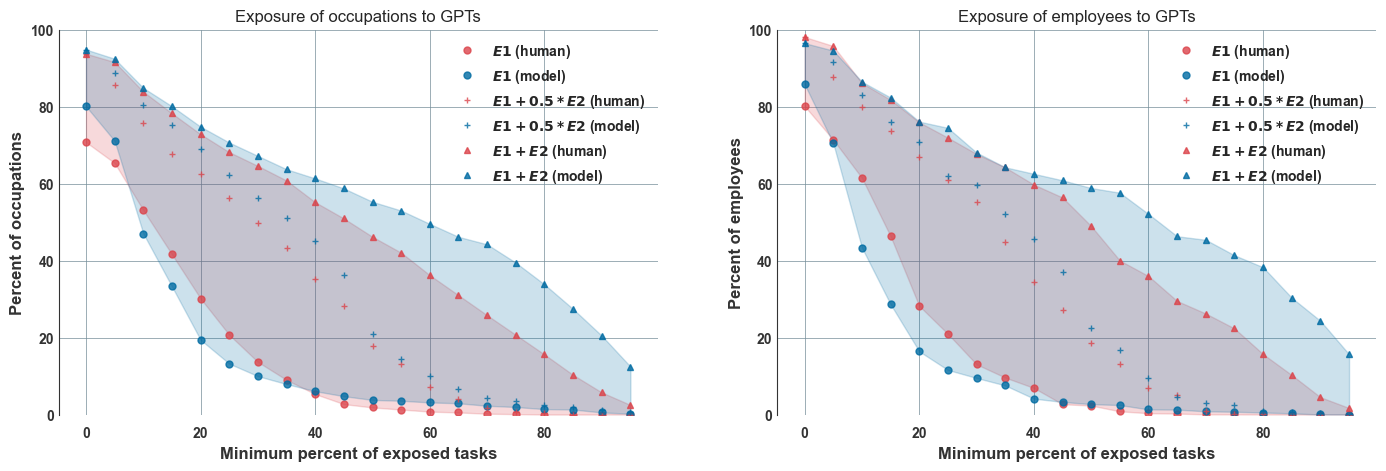

In [239]:
def sns_exposure_plot(
    list_of_dfs_human,
    list_of_dfs_model,
    list_of_labels,
    title,
    ylabel,
    xlabel,
    filename,
    variable="percent",
    ax=None,
):
    params = FINAL_PLOT_PARAMS
    sns.set_style("whitegrid")
    sns.set_palette("bright")
    plt.rcParams.update(params)
    # plus-sign marker

    markers = ["o", "+", "^"]

    # add shading between list_of_dfs_human[0] and list_of_dfs_human[2]
    for i in range(len(list_of_dfs_model)):
        # if i==1 then make the marker smaller
        if i == 1:
            ax.plot(
                list_of_dfs_human[i]["threshold"],
                list_of_dfs_human[i][variable],
                label=list_of_labels[i],
                linestyle="None",
                marker=markers[i],
                alpha=0.8,
                color="#DB444B",
                markersize=4,
            )  # red
            ax.plot(
                list_of_dfs_model[i]["threshold"],
                list_of_dfs_model[i][variable],
                label=list_of_labels[i + 3],
                linestyle="None",
                marker=markers[i],
                alpha=0.8,
                color="#006BA2",
                markersize=4,
            )  # blue
        else:
            ax.plot(
                list_of_dfs_human[i]["threshold"],
                list_of_dfs_human[i][variable],
                label=list_of_labels[i],
                linestyle="None",
                marker=markers[i],
                alpha=0.8,
                color="#DB444B",
                markersize=5,
            )  # red
            ax.plot(
                list_of_dfs_model[i]["threshold"],
                list_of_dfs_model[i][variable],
                label=list_of_labels[i + 3],
                linestyle="None",
                marker=markers[i],
                alpha=0.8,
                color="#006BA2",
                markersize=5,
            )  # blue

    ax.fill_between(
        list_of_dfs_human[0]["threshold"],
        list_of_dfs_human[0][variable],
        list_of_dfs_human[2][variable],
        color="#DB444B",
        alpha=0.2,
    )
    ax.fill_between(
        list_of_dfs_model[0]["threshold"],
        list_of_dfs_model[0][variable],
        list_of_dfs_model[2][variable],
        color="#006BA2",
        alpha=0.2,
    )

    ax.set_ylim(0, 100)

    # add a legend
    ax.legend(loc="upper right", frameon=False)
    # add shading between list_of_dfs_model[0] and list_of_dfs_model[2]
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    filepath = "../data/vecfigs/{filename}"
    ax.set_title(title)

    # Return the dataframes used for plotting
    return list_of_dfs_human, list_of_dfs_model


exposure_2023_expected_human_occ_a = get_exposure_points(
    get_percentages(final_data_w_labels, "human_exposure"), type="occupation"
)
exposure_2023_expected_human_emp_a = get_exposure_points(
    get_percentages(final_data_w_labels, "human_exposure", ["TOT_EMP"]),
    type="employee",
)
exposure_2023_expected_model_occ_a = get_exposure_points(
    get_percentages(final_data_w_labels, "gpt4_exposure"), type="occupation"
)
exposure_2023_expected_model_emp_a = get_exposure_points(
    get_percentages(final_data_w_labels, "gpt4_exposure", ["TOT_EMP"]), type="employee"
)

# now do the same for relevance_type="b" and then relevance_type="c"
exposure_2023_expected_human_occ_b = get_exposure_points(
    get_percentages(final_data_w_labels, "human_exposure"),
    type="occupation",
    relevance_type="b",
)
exposure_2023_expected_human_emp_b = get_exposure_points(
    get_percentages(final_data_w_labels, "human_exposure", ["TOT_EMP"]),
    type="employee",
    relevance_type="b",
)
exposure_2023_expected_model_occ_b = get_exposure_points(
    get_percentages(final_data_w_labels, "gpt4_exposure"),
    type="occupation",
    relevance_type="b",
)
exposure_2023_expected_model_emp_b = get_exposure_points(
    get_percentages(final_data_w_labels, "gpt4_exposure", ["TOT_EMP"]),
    type="employee",
    relevance_type="b",
)

# and relevance_type = "c"
exposure_2023_expected_human_occ_c = get_exposure_points(
    get_percentages(final_data_w_labels, "human_exposure"),
    type="occupation",
    relevance_type="c",
)
exposure_2023_expected_human_emp_c = get_exposure_points(
    get_percentages(final_data_w_labels, "human_exposure", ["TOT_EMP"]),
    type="employee",
    relevance_type="c",
)
exposure_2023_expected_model_occ_c = get_exposure_points(
    get_percentages(final_data_w_labels, "gpt4_exposure"),
    type="occupation",
    relevance_type="c",
)
exposure_2023_expected_model_emp_c = get_exposure_points(
    get_percentages(final_data_w_labels, "gpt4_exposure", ["TOT_EMP"]),
    type="employee",
    relevance_type="c",
)

# make a plot with the human and model exposure points for occupations and all relevance_types, shade between relevance_type="a" and "c"
# fig, axes = plt.subplots(2, 2, figsize=(10,10))
# make two plots side by side that share a single legend
fig, axes = plt.subplots(1, 2, figsize=(17, 5))
occ_human_dfs, occ_model_dfs = sns_exposure_plot(
    [
        exposure_2023_expected_human_occ_a,
        exposure_2023_expected_human_occ_b,
        exposure_2023_expected_human_occ_c,
    ],
    [
        exposure_2023_expected_model_occ_a,
        exposure_2023_expected_model_occ_b,
        exposure_2023_expected_model_occ_c,
    ],
    # exposure labels for human and model
    [
        r"$E1$ (human)",
        r"$E1+0.5*E2$ (human)",
        r"$E1+E2$ (human)",
        r"$E1$ (model)",
        r"$E1+0.5*E2$ (model)",
        r"$E1+E2$ (model)",
    ],
    "Exposure of occupations to GPTs",
    "Percent of occupations",
    "Minimum percent of exposed tasks",
    "exposure_occupations_newest.svg",
    ax=axes[0],
)
# do the same for the employee exposure points
emp_human_dfs, emp_model_dfs = sns_exposure_plot(
    [
        exposure_2023_expected_human_emp_a,
        exposure_2023_expected_human_emp_b,
        exposure_2023_expected_human_emp_c,
    ],
    [
        exposure_2023_expected_model_emp_a,
        exposure_2023_expected_model_emp_b,
        exposure_2023_expected_model_emp_c,
    ],
    # exposure labels for human and model
    [
        r"$E1$ (human)",
        r"$E1+0.5*E2$ (human)",
        r"$E1+E2$ (human)",
        r"$E1$ (model)",
        r"$E1+0.5*E2$ (model)",
        r"$E1+E2$ (model)",
    ],
    "Exposure of employees to GPTs",
    "Percent of employees",
    "Minimum percent of exposed tasks",
    "exposure_employees_newest.svg",
    ax=axes[1],
)

In [240]:
def label_fig2c_series(dflist, seriestype="human"):
    for i in range(len(dflist)):
        if i == 0:
            dflist[i]["label"] = f"E1 ({seriestype})"
        elif i == 1:
            dflist[i]["label"] = f"E1+0.5*E2 ({seriestype})"
        else:
            dflist[i]["label"] = f"E1+E2 ({seriestype})"
    return dflist


for df in [occ_human_dfs, emp_human_dfs]:
    df = label_fig2c_series(df, seriestype="human")
for df in [occ_model_dfs, emp_model_dfs]:
    df = label_fig2c_series(df, seriestype="model")

for df in occ_human_dfs + occ_model_dfs:
    df["graphtype"] = "percent of occupations"
for df in emp_human_dfs + emp_model_dfs:
    df["graphtype"] = "percent of employees"

### generate the data for the plot above
all_data_fig2c = pd.concat(
    occ_human_dfs + occ_model_dfs + emp_human_dfs + emp_model_dfs,
    axis=0,
    ignore_index=True,
)

##### Job Zones

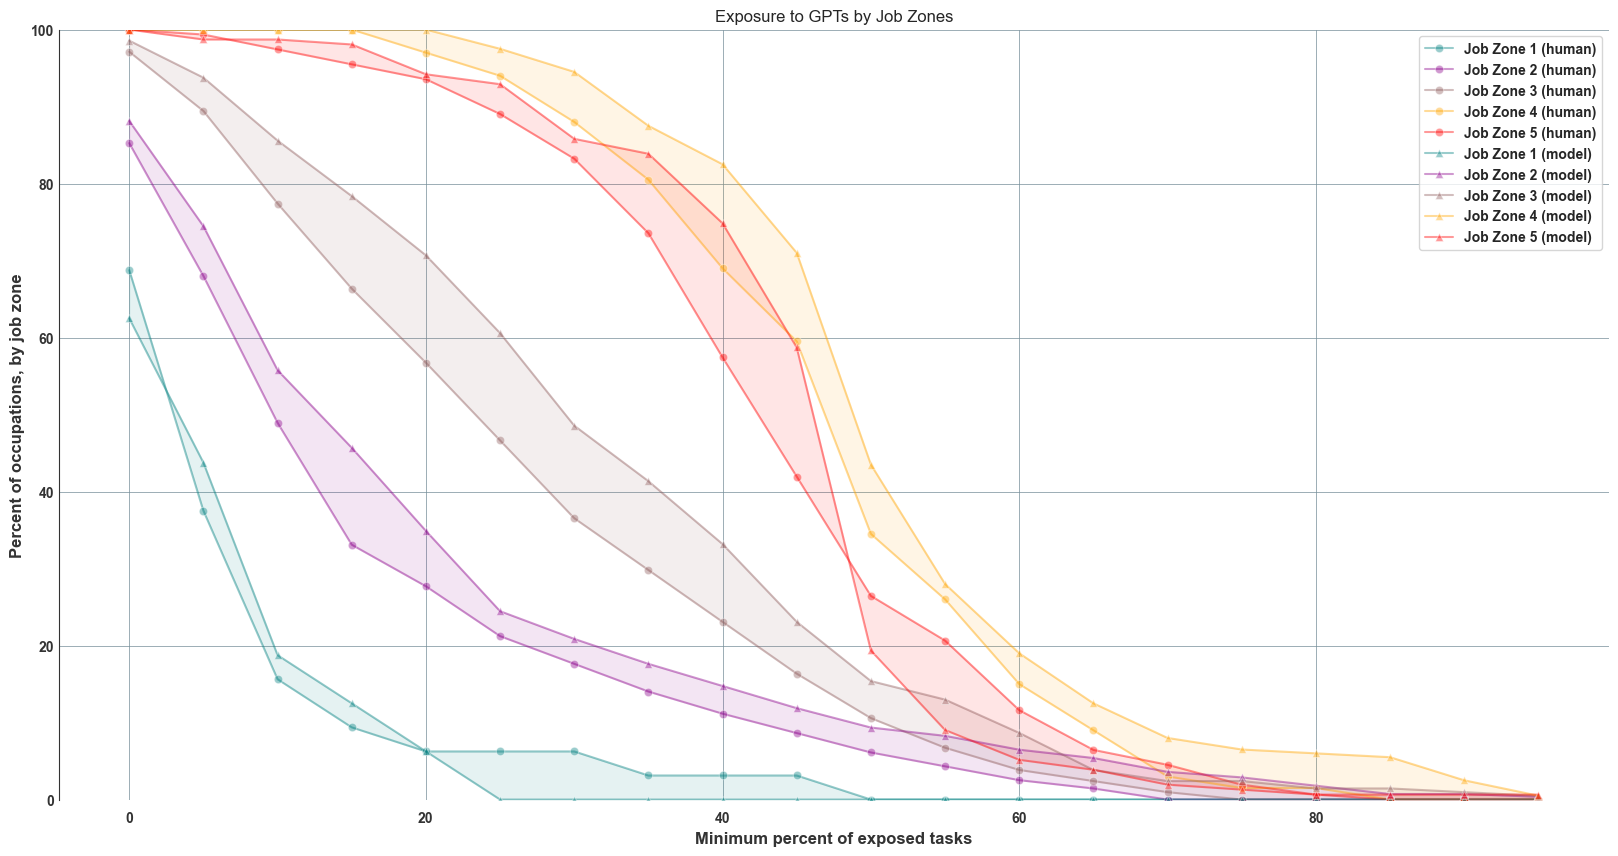

In [241]:
def get_exposure_points_jobzone(df, type="occupation"):
    thresholds = np.arange(0, 100, 5)
    job_zones = df["job zone"].unique()
    exposure_df = pd.DataFrame()
    for job_zone in job_zones:
        exposure = {}
        df_subset = df[df["job zone"] == job_zone]
        for threshold in thresholds:
            # exposure[threshold] = df_subset[df_subset['gpt_relevance'] > threshold].shape[0] if type == "occupation" else df_subset[df_subset['gpt_relevance'] > threshold]['TOT_EMP'].sum()
            exposure[threshold] = (
                df_subset[df_subset["gpt_relevance_b"] > threshold].shape[0]
                if type == "occupation"
                else df_subset[df_subset["gpt_relevance_b"] > threshold][
                    "TOT_EMP"
                ].sum()
            )
        exposure_subset = pd.DataFrame.from_dict(
            exposure, orient="index", columns=["count"]
        )
        exposure_subset["threshold"] = exposure_subset.index
        exposure_subset["percent"] = (
            exposure_subset["count"] / len(df_subset) * 100
            if type == "occupation"
            else exposure_subset["count"] / sum(df_subset["TOT_EMP"]) * 100
        )
        exposure_subset["job zone"] = job_zone
        exposure_df = pd.concat([exposure_df, exposure_subset])
    return exposure_df


def sns_exposure_plot_jobzone(
    list_of_dfs,
    list_of_labels,
    title,
    ylabel,
    xlabel,
    filename,
    variable="percent",
    ax=None,
):
    sns.set_style("whitegrid")
    # set a unique color for each job zone category
    sns.set_palette(
        sns.color_palette("bright", len(list_of_dfs[0]["job zone"].unique()))
    )
    plt.rcParams.update(FINAL_PLOT_PARAMS)

    # get the unique job zone categories from the first dataframe in the list
    job_zones = list_of_dfs[0]["job zone"].unique()
    # sort the job zones
    job_zones.sort()

    fig, ax = plt.subplots(figsize=(20, 10))

    markers = ["o", "^"]
    # colors = ["#3EBCD2", "#379A8B", "#EBB434", "#B4BA39", "#9A607F"]
    # colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
    # colors = ["#8A5ABE", "#268C5A", "#B2322F", "#FF8C00", "#3573A4"]
    colors = ["#008080", "#8B008B", "#905D5D", "#FFA500", "#FF0000"]
    # colors = ["#8B5A2B", "#5D3B2E", "#006400", "#556B2F", "#CD853F"]
    # fix the y-axis to be between 0 and 100

    for j in range(len(list_of_dfs)):
        for i, job_zone in enumerate(job_zones):
            # subset the dataframe to only include the current job zone
            df_subset = list_of_dfs[j][list_of_dfs[j]["job zone"] == job_zone]
            sns.lineplot(
                x="threshold",
                y=variable,
                data=df_subset,
                label="Job Zone {1} {0}".format(list_of_labels[j], int(job_zone)),
                color=colors[i],
                linestyle="-",
                marker=markers[j],
                alpha=0.4,
                ax=ax,
            )

    for i, job_zone in enumerate(job_zones):
        df_human = list_of_dfs[0][list_of_dfs[0]["job zone"] == job_zone]
        df_model = list_of_dfs[1][list_of_dfs[1]["job zone"] == job_zone]
        ax.fill_between(
            df_human["threshold"],
            df_human["percent"],
            df_model["percent"],
            alpha=0.1,
            color=colors[i],
        )

    ax.legend()
    ax.set_ylim(0, 100)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)


exposure_2023_expected_human_jobzone = get_exposure_points_jobzone(
    get_percentages(final_data_w_labels, "human_exposure", ["job zone"])
)
exposure_2023_expected_model_jobzone = get_exposure_points_jobzone(
    get_percentages(final_data_w_labels, "gpt4_exposure", ["job zone"])
)

# exposure_2023_expected_human_jobzone = get_exposure_points_jobzone(get_percentages(final_data_w_labels, '2023_expected_human', ["TOT_EMP", "job zone"]), type="workers")
# exposure_2023_expected_model_jobzone = get_exposure_points_jobzone(get_percentages(final_data_w_labels, '2023_expected_model', ['TOT_EMP', 'job zone']), type="workers")

sns_exposure_plot_jobzone(
    [exposure_2023_expected_human_jobzone, exposure_2023_expected_model_jobzone],
    ["(human)", "(model)"],
    "Exposure to GPTs by Job Zones",
    "Percent of occupations, by job zone",
    "Minimum percent of exposed tasks",
    "exposure_2023_expected_human_jobzone_newest.svg",
    variable="percent",
)

In [242]:
print(
    exposure_2023_expected_human_jobzone[
        exposure_2023_expected_human_jobzone["job zone"] == 5.0
    ]
)

    count  threshold     percent  job zone
0     155          0  100.000000       5.0
5     154          5   99.354839       5.0
10    151         10   97.419355       5.0
15    148         15   95.483871       5.0
20    145         20   93.548387       5.0
25    138         25   89.032258       5.0
30    129         30   83.225806       5.0
35    114         35   73.548387       5.0
40     89         40   57.419355       5.0
45     65         45   41.935484       5.0
50     41         50   26.451613       5.0
55     32         55   20.645161       5.0
60     18         60   11.612903       5.0
65     10         65    6.451613       5.0
70      7         70    4.516129       5.0
75      3         75    1.935484       5.0
80      1         80    0.645161       5.0
85      0         85    0.000000       5.0
90      0         90    0.000000       5.0
95      0         95    0.000000       5.0


##### Looking at skills

In [243]:
all_tasks_skills = get_skill_correlations(
    [
        get_percentages(final_data_w_labels, "human_exposure", ["A_MEDIAN_LOG"]),
        get_percentages(final_data_w_labels, "gpt4_exposure", ["A_MEDIAN_LOG"]),
    ],
    ["2023_Human", "2023_Model"],
    skills_df,
    basic_skills,
)

skills_df_new:                      skill  exposure_corr_2023_Human
0        active_listening                     0.559
1             mathematics                     0.319
2   reading_comprehension                     0.590
3                 science                     0.214
4                speaking                     0.578
5                 writing                     0.600
6         active_learning                     0.458
7       critical_thinking                     0.449
8     learning_strategies                     0.386
9              monitoring                     0.182
10            programming                     0.387
skills_df_new:                      skill  exposure_corr_2023_Model
0        active_listening                     0.174
1             mathematics                     0.108
2   reading_comprehension                     0.243
3                 science                    -0.006
4                speaking                     0.129
5                 writing       

In [244]:
def normalize_skills(list_of_dfs, list_of_stubs, skills_df, skills_list):
    big_df = None
    for df, stub in zip(list_of_dfs, list_of_stubs):

        skills_results = []
        df_skills = list_of_dfs[0]
        for sk in skills_list:
            sk = sk.replace(" ", "_")
            # for all the skills in basic skills, replace "Not Relevant" and "Not Available" with NaN, then convert to float
            df_skills[f"{sk}_level"] = (
                df_skills[f"{sk}_level"]
                .replace(["Not relevant", "Not available"], "NaN")
                .astype(float)
            )
            # normalize the skill level to be between 0 and 1
            min_val = df_skills[f"{sk}_importance"].min()
            max_val = df_skills[f"{sk}_importance"].max()
            df_skills[f"{sk}_importance_normalized"] = (
                df_skills[f"{sk}_importance"] - min_val
            ) / (max_val - min_val)
    return df_skills


final_data_skills = normalize_skills(
    [final_data_w_labels], [""], skills_df, basic_skills
)
final_data_skills.columns


# run a regression of E1_dummy on all the skills

var_list = []
for sk in basic_skills:
    var = f"{sk}_importance_normalized"
    var_list.append(var)

import statsmodels.api as sm

# Define the independent variables

final_data_skills["E1_half_dummy"] = (
    final_data_skills["E1_dummy"] + 0.5 * final_data_skills["E2_dummy"]
)
final_data_skills["E1_E2"] = (
    final_data_skills["E1_dummy"] + final_data_skills["E2_dummy"]
)

# Define the dependent variable
dependent_variable = "E1_dummy"
# dependent_variable = 'E1_half_dummy'
# dependent_variable = 'E1_E2'

independent_variables = [
    "active_listening_importance_normalized",
    "mathematics_importance_normalized",
    "reading_comprehension_importance_normalized",
    "science_importance_normalized",
    "speaking_importance_normalized",
    "writing_importance_normalized",
    "active_learning_importance_normalized",
    "critical_thinking_importance_normalized",
    "learning_strategies_importance_normalized",
    "monitoring_importance_normalized",
    "programming_importance_normalized",
]

# Extract the independent and dependent variables from the dataframe
final_data_skills = final_data_skills.replace(
    [np.inf, -np.inf], np.nan
)  # replace infinite values with NaNs
final_data_skills = final_data_skills.dropna(
    subset=independent_variables + [dependent_variable]
)

X = final_data_skills[independent_variables]
y = final_data_skills[dependent_variable]

# Add a constant term to the independent variables matrix to account for the intercept
X = sm.add_constant(X)

# Fit the model
# model = sm.OLS(y, X).fit()
model = sm.OLS(y, X).fit(cov_type="HC1")  # Newey-West covariance estimator
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               E1_dummy   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     166.1
Date:                Sun, 01 Dec 2024   Prob (F-statistic):               0.00
Time:                        15:20:12   Log-Likelihood:                -6238.3
No. Observations:               18291   AIC:                         1.250e+04
Df Residuals:                   18279   BIC:                         1.259e+04
Df Model:                          11                                         
Covariance Type:                  HC1                                         
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          -0.0877      0.011     -7.882      0.000      -0.110      -0.066
active_listening_importance_normalized          0.0343      0.045      0.763      0.445      -0.054       0.122
mathematics_importance_normalized               0.0535      0.027      2.008      0.045       0.001       0.106
reading_comprehension_importance_normalized     0.1851      0.040      4.604      0.000       0.106       0.264
science_importance_normalized                  -0.0803      0.017     -4.859      0.000      -0.113      -0.048
speaking_importance_normalized                  0.2771      0.038      7.345      0.000       0.203       0.351
writing_importance_normalized                   0.3201      0.041      7.884      0.000       0.241       0.400
active_learning_importance_normalized          -0.0624      0.028     -2.263      0.024      -0.116      -0.008
critical_thinking_importance_normalized        -0.1509      0.034     -4.393      0.000      -0.218      -0.084
learning_strategies_importance_normalized      -0.0249      0.030     -0.825      0.409      -0.084       0.034
monitoring_importance_normalized               -0.1788      0.024     -7.548      0.000      -0.225      -0.132
programming_importance_normalized               0.1942      0.028      6.948      0.000       0.139       0.249
==============================================================================
Omnibus:                     5127.030   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10744.590
Skew:                           1.720   Prob(JB):                         0.00
Kurtosis:                       4.503   Cond. No.                         42.6
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [245]:
final_data_skills["E1_half_dummy"] = (
    final_data_skills["E1_dummy"] + 0.5 * final_data_skills["E2_dummy"]
)
final_data_skills["E1_E2"] = (
    final_data_skills["E1_dummy"] + final_data_skills["E2_dummy"]
)
final_data_demo = copy.deepcopy(final_data_skills)
# replace the 'women', 'black', 'asian', 'hispanic' columns, s.t. all non-numerical values are replaced with NaN, with regex
for col in ["women", "black", "asian", "hispanic"]:
    final_data_demo[col] = (
        final_data_demo[col].replace(r"[^0-9.]+", np.nan, regex=True).astype(float)
    )

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_12941/1255556826.py:11: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_12941/1255556826.py:11: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_12941/1255556826.py:11: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in 

In [246]:
# Define the dependent variable
dependent_variable = "E1_dummy"

demo_independent_variables = ["women", "black", "asian", "hispanic"]
# change these data to be between 0 and 1, by dividing by 100
# replace non-numeric values with NaNs, using regex


final_data_demo = final_data_demo.replace(
    [np.inf, -np.inf], np.nan
)  # replace infinite values with NaNs
final_data_demo = final_data_demo.dropna(
    subset=demo_independent_variables + [dependent_variable]
)

X = final_data_demo[demo_independent_variables]
for var in demo_independent_variables:
    X[var] = X[var] / 100

y = final_data_demo[dependent_variable]

# Add a constant term to the independent variables matrix to account for the intercept
X = sm.add_constant(X)

# Fit the model
# model = sm.OLS(y, X).fit()
model = sm.OLS(y, X).fit(cov_type="HC1")  # Newey-West covariance estimator
model.summary()

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_12941/1585464498.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               E1_dummy   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     67.09
Date:                Sun, 01 Dec 2024   Prob (F-statistic):           9.26e-56
Time:                        15:20:12   Log-Likelihood:                -2895.0
No. Observations:                6795   AIC:                             5800.
Df Residuals:                    6790   BIC:                             5834.
Df Model:                           4                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1814      0.014     12.509      0.000       0.153       0.210
women          0.0961      0.016      6.017      0.000       0.065       0.127
black         -0.0794      0.066     -1.204      0.229      -0.209       0.050
asian          0.2231      0.083      2.674      0.008       0.060       0.387
hispanic      -0.3934      0.040     -9.811      0.000      -0.472      -0.315
==============================================================================
Omnibus:                     1799.335   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3579.547
Skew:                           1.702   Prob(JB):                         0.00
Kurtosis:                       4.027   Cond. No.                         19.9
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

#### Weights analysis

In [247]:
## clean the importance ratings dataset
df_taskratings_relevant = df_taskratings[df_taskratings["Scale ID"].isin(["RT", "IM"])][
    ["O*NET-SOC Code", "Task ID", "Scale ID", "Data Value"]
]
dfr_taskratings = pd.pivot(
    df_taskratings_relevant, index=["O*NET-SOC Code", "Task ID"], columns=["Scale ID"]
).reset_index()
dfr_taskratings.columns = ["O*NET-SOC Code", "Task ID", "importance", "relevance"]

task_tmp = pd.merge(
    df_tasks, dfr_taskratings, how="left", on=["O*NET-SOC Code", "Task ID"]
)

## sort the dataset by the task_id
full_labels = full_labels.sort_values(by=["Task ID"])
## remove decimal from task_id
full_labels["Task ID"] = full_labels["Task ID"].astype(int)
full_labels.head()

## make Task ID numeric/float with one decimal place
df_tasks["Task ID"] = df_tasks["Task ID"].astype(int)
df_tasks = df_tasks.sort_values(by=["Task ID"])
df_tasks.head()

# check that Task ID is unique in both datasets
print(
    f"Number of unique Task IDs in oai_labels: {len(full_labels['Task ID'].unique())}"
)
print(f"Number of unique Task IDs in df_tasks: {len(df_tasks['Task ID'].unique())}")

## Add a core_weight column to df_tasks =2 if core, =1 if supplemental
df_tasks["core_weight"] = np.where(df_tasks["Task Type"] == "Core", 2, 1)

## Add a core_weight_tot column that is the sum of the core_weight column for each SOC code
df_tasks["core_weight_tot"] = df_tasks.groupby("O*NET-SOC Code")[
    "core_weight"
].transform("sum")

## gen final core/supplemental task weighting
df_tasks["core_weight_"] = df_tasks["core_weight"] / df_tasks["core_weight_tot"]
df_tasks.head()

Number of unique Task IDs in oai_labels: 19265
Number of unique Task IDs in df_tasks: 19265


,Unnamed: 0,O*NET-SOC Code,Task ID,Task,Task Type,Title,coreweight,equalweight,core_weight,core_weight_tot,core_weight_
147,147,11-2022.00,1,Resolve customer complaints regarding sales an...,Core,Sales Managers,2,1,2,30,0.066667
152,152,11-2022.00,2,Monitor customer preferences to determine focu...,Core,Sales Managers,2,1,2,30,0.066667
146,146,11-2022.00,3,Direct and coordinate activities involving sal...,Core,Sales Managers,2,1,2,30,0.066667
150,150,11-2022.00,4,Determine price schedules and discount rates.,Core,Sales Managers,2,1,2,30,0.066667
148,148,11-2022.00,5,Review operational records and reports to proj...,Core,Sales Managers,2,1,2,30,0.066667


In [248]:
temp_labels = copy.deepcopy(full_labels_weight)

temp_labels["human_beta_core"] = temp_labels["human_beta"] * temp_labels["core_weight"]
temp_labels["human_beta_importance"] = (
    temp_labels["human_beta"] * temp_labels["importance_weight"]
)
temp_labels["gpt4_beta_core"] = temp_labels["gpt4_beta"] * temp_labels["core_weight"]
temp_labels["gpt4_beta_importance"] = (
    temp_labels["gpt4_beta"] * temp_labels["importance_weight"]
)

agg_functions = {
    "human_beta_core": "sum",
    "human_beta_importance": "sum",
    "gpt4_beta_core": "sum",
    "gpt4_beta_importance": "sum",
    "core_weight": "sum",
    "importance_weight": "sum",
}

occ_agg = (
    temp_labels.groupby(["O*NET-SOC Code", "Title"]).agg(agg_functions).reset_index()
)

occ_agg["core_weighted_avg_human_rating"] = (
    occ_agg["human_beta_core"] / occ_agg["core_weight"]
)
occ_agg["importance_weighted_avg_human_rating"] = (
    occ_agg["human_beta_importance"] / occ_agg["importance_weight"]
)
occ_agg["core_weighted_avg_gpt4_rating"] = (
    occ_agg["gpt4_beta_core"] / occ_agg["core_weight"]
)
occ_agg["importance_weighted_avg_gpt4_rating"] = (
    occ_agg["gpt4_beta_importance"] / occ_agg["importance_weight"]
)

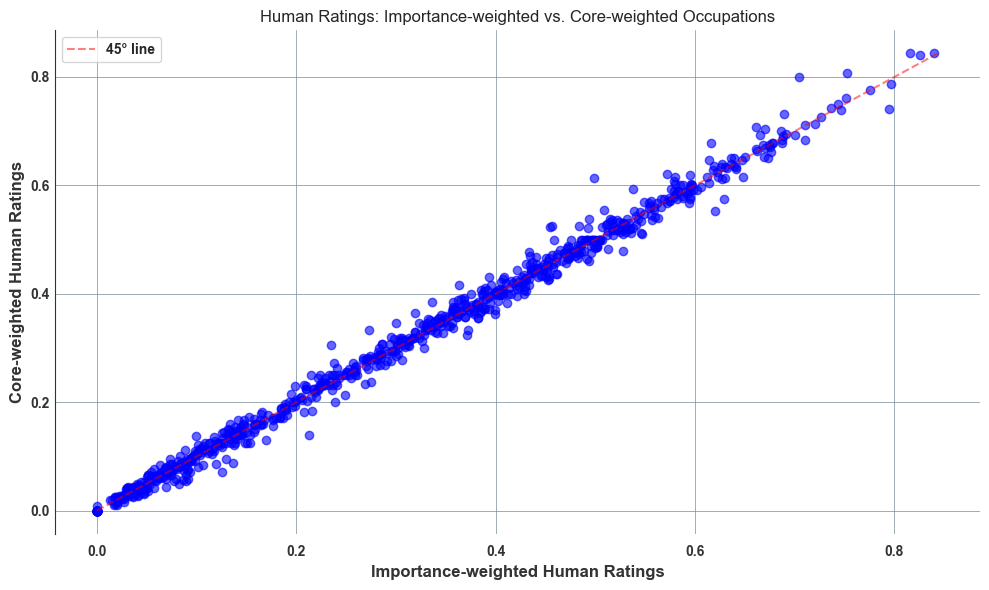

In [249]:
'''
plt.scatter(
    occ_labels["importance_weighted_avg_human_rating"],
    occ_labels["core_weighted_avg_human_rating"],
    c="b",
)

plt.xlabel("Importance-weighted Human Ratings")
plt.ylabel("Core-weighted Human Ratings")
plt.title("Human Ratings: Importance-weighted vs. Core-weighted Occupations")
plt.grid(True)
plt.show()
'''
plt.figure(figsize=(10, 6))
plt.scatter(
    occ_agg["importance_weighted_avg_human_rating"],
    occ_agg["core_weighted_avg_human_rating"],
    c="b",
    alpha=0.6
)

plt.xlabel("Importance-weighted Human Ratings")
plt.ylabel("Core-weighted Human Ratings")
plt.title("Human Ratings: Importance-weighted vs. Core-weighted Occupations")
plt.grid(True)

# Add a 45-degree line for reference
min_val = min(
    occ_agg["importance_weighted_avg_human_rating"].min(),
    occ_agg["core_weighted_avg_human_rating"].min()
)
max_val = max(
    occ_agg["importance_weighted_avg_human_rating"].max(),
    occ_agg["core_weighted_avg_human_rating"].max()
)
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='45° line')

plt.legend()
plt.tight_layout()
plt.show()

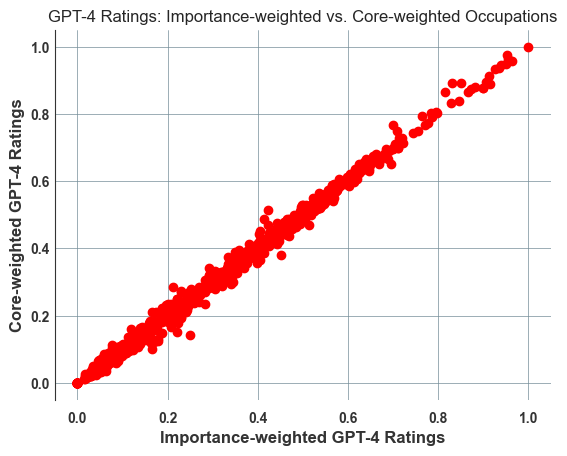

In [250]:
plt.scatter(
    occ_agg["importance_weighted_avg_gpt4_rating"],
    occ_agg["core_weighted_avg_gpt4_rating"],
    c="r",
)
plt.xlabel("Importance-weighted GPT-4 Ratings")
plt.ylabel("Core-weighted GPT-4 Ratings")
plt.title("GPT-4 Ratings: Importance-weighted vs. Core-weighted Occupations")
plt.grid(True)
plt.show()

In [251]:
## sankey plot for agreement
### Sankey diagram
import plotly.graph_objects as go

# Assuming oai_labels is your DataFrame
# Group by the columns and count the occurrences
flow_counts = (
    full_labels.groupby(["human_exposure", "gpt4_exposure", "gpt4_alt_exposure"])
    .size()
    .reset_index(name="counts")
)

# Define labels
labels = ["E0", "E1", "E2"]

# Prepare source, target, and value
source, target, value = [], [], []
for index, row in flow_counts.iterrows():
    source.append(labels.index(row["human_exposure"]))
    target.append(
        labels.index(row["gpt4_exposure"]) + 3
    )  # Adding 3 to distinguish gpt4_exposure
    value.append(row["counts"])

    source.append(labels.index(row["gpt4_exposure"]) + 3)
    target.append(
        labels.index(row["gpt4_alt_exposure"]) + 6
    )  # Adding 6 to distinguish gpt4_alt_exposure
    value.append(row["counts"])

labels = labels + [f"{label}" for label in labels] + [f"{label}" for label in labels]

# Define lighter color mapping for links
color_map = {"E0": "skyblue", "E1": "lightcoral", "E2": "#F0E68C"}

# Prepare source, target, value, and link colors
source, target, value, link_colors = [], [], [], []
for index, row in flow_counts.iterrows():
    color = color_map[
        row["human_exposure"]
    ]  # Get the color based on the 'human_exposure' value

    source.append(labels.index(row["human_exposure"]))
    target.append(labels.index(row["gpt4_exposure"]) + 3)
    value.append(row["counts"])
    link_colors.append(color)

    source.append(labels.index(row["gpt4_exposure"]) + 3)
    target.append(labels.index(row["gpt4_alt_exposure"]) + 6)
    value.append(row["counts"])
    link_colors.append(color)

# Define colors for nodes as white
colors = ["white"] * len(labels)  # Set all nodes to white

# Create Sankey Diagram with white nodes and custom link colors
fig = go.Figure(
    data=[
        go.Sankey(
            node=dict(
                pad=15,
                thickness=15,
                line=dict(color="black", width=0.5),
                label=labels,
                color=colors,
            ),
            link=dict(source=source, target=target, value=value, color=link_colors),
        )
    ]
)

# Add annotations (titles) for the three groups of nodes
fig.add_annotation(
    text="Human", x=0, y=1.1, yref="paper", showarrow=False, font=dict(size=10)
)
fig.add_annotation(
    text="GPT-4 Rubric 1",
    x=0.5,
    y=1.1,
    yref="paper",
    showarrow=False,
    font=dict(size=10),
)
fig.add_annotation(
    text="GPT-4 Rubric 2", x=1, y=1.1, yref="paper", showarrow=False, font=dict(size=10)
)
fig.show()